<a href="https://colab.research.google.com/github/MOSSAWIII/TopicModeling_Yelp/blob/main/TopicModeling_Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECTION 1: DATA PREPARATION AND PREPROCESSING

## 1.1 Initial Setup

In [3]:
import pandas as pd
import numpy as np
import json
import wget
import re
import nltk
import spacy
import langdetect
from collections import Counter
from typing import List, Dict, Tuple
from sklearn.model_selection import train_test_split

# Text processing libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim.downloader as api

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Configure visualizations
sns.set_style('whitegrid')


## 1.2 Data Loading and Sampling


In [4]:
def load_and_prepare_data(file_path: str, sample_size: float = 0.1) -> pd.DataFrame:
    """
    Loads data and creates a stratified sample

    Args:
        file_path: Path to the JSON file
        sample_size: Proportion of data to sample (default: 0.1 for 10%)
    """
    # Load JSON data
    with open(file_path, 'r') as json_file:
        data_review = json.load(json_file)
        data_review = json.loads(data_review)
        data_review = pd.DataFrame(data_review)

    # Basic cleaning
    data_review = data_review.dropna(subset=['text'])
    data_review = data_review.drop_duplicates(subset=['text'])

    # Create stratified sample
    _, sampled_data = train_test_split(
        data_review,
        test_size=sample_size,
        random_state=42,
        stratify=data_review['stars']
    )

    return sampled_data

def language_detector(df: pd.DataFrame) -> Dict[int, str]:
    """Detect the language for a given string."""
    languages_langdetect = dict()
    for index, row in df.iterrows():
        try:
            result = langdetect.detect_langs(row["text"])
            languages_langdetect[index] = str(result[0])[:2]
        except Exception:
            languages_langdetect[index] = 'unknown'
    return languages_langdetect

In [5]:
# Download and load the data with sampling
url = "https://cifre.s3.eu-north-1.amazonaws.com/mini_review.json"
wget.download(url)
data_review = load_and_prepare_data('./mini_review.json', sample_size=0.1)

In [6]:
# Detect languages
print("\nDetecting languages for sampled data...")
languages = language_detector(data_review)
data_review.insert(loc=0, column='Language', value=pd.Series(languages))


Detecting languages for sampled data...


In [7]:
# Filter English reviews only
data_review = data_review[data_review['Language'] == 'en']

In [8]:
print("\nOriginal dataset shape:", data_review.shape)
print("\nRating distribution in sample:")
display(data_review['stars'].value_counts(normalize=True).round(3))
print("\nLanguage distribution in sample:")
display(data_review['Language'].value_counts())


Original dataset shape: (4885, 10)

Rating distribution in sample:


,proportion
stars,
5.0,0.430
4.0,0.200
1.0,0.184
3.0,0.102
2.0,0.084



Language distribution in sample:


,count
Language,
en,4885


## 1.3 Text Preprocessing Pipeline

In [9]:
def preprocess_text(text: str) -> str:
    """
    Preprocesses the text data for topic modeling
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Add custom stopwords relevant to Yelp reviews
    custom_stopwords = {'food', 'restaurant', 'place', 'would', 'could', 'really',
                       'get', 'one', 'go', 'went', 'got', 'ordered', 'like',
                       'good', 'great', 'amazing', 'best', 'better', 'worse',
                       'worst', 'bad', 'terrible', 'awesome', 'excellent'}
    stop_words.update(custom_stopwords)
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [12]:
# Apply preprocessing
print("Preprocessing English texts...")
data_review['processed_text'] = data_review['text'].apply(preprocess_text)

Preprocessing English texts...


In [13]:
# Display sample results
print("\nPreprocessing Results Sample:")
for orig, proc in zip(data_review['text'].head(2), data_review['processed_text'].head(2)):
    print("\nOriginal:", orig[:100], "...")
    print("Processed:", proc[:100], "...")


Preprocessing Results Sample:

Original: Great location and the overall golf course is well maintained. The staff wore masks and was very fri ...
Processed: great location overall golf course well maintained staff wore mask friendly downside wanted cart aka ...

Original: Great Service, Great Food. Everything was cooked to the tens.  Will return and will recommend to all ...
Processed: great service great everything cooked ten return recommend seafood loving friend similar low country ...


# SECTION 2: EXPLORATORY TEXT ANALYSIS

## 2.1 Basic Text Statistics

In [16]:
# First, calculate text length and word count
data_review['text_length'] = data_review['text'].str.len()
data_review['word_count'] = data_review['processed_text'].str.split().str.len()
data_review['unique_words'] = data_review['processed_text'].apply(lambda x: len(set(x.split())))

def get_text_statistics(df: pd.DataFrame) -> Dict:
    """Calculate basic text statistics"""
    stats = {
        'total_reviews': len(df),
        'avg_length': df['text_length'].mean(),
        'median_length': df['text_length'].median(),
        'avg_words': df['word_count'].mean(),
        'total_unique_words': len(set(' '.join(df['processed_text']).split())),
        'avg_unique_words': df['unique_words'].mean()
    }
    return stats

In [17]:
# Calculate and display statistics
stats = get_text_statistics(data_review)
print("Basic Text Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

Basic Text Statistics:
total_reviews: 4885.00
avg_length: 494.08
median_length: 347.00
avg_words: 41.98
total_unique_words: 12910.00
avg_unique_words: 36.29


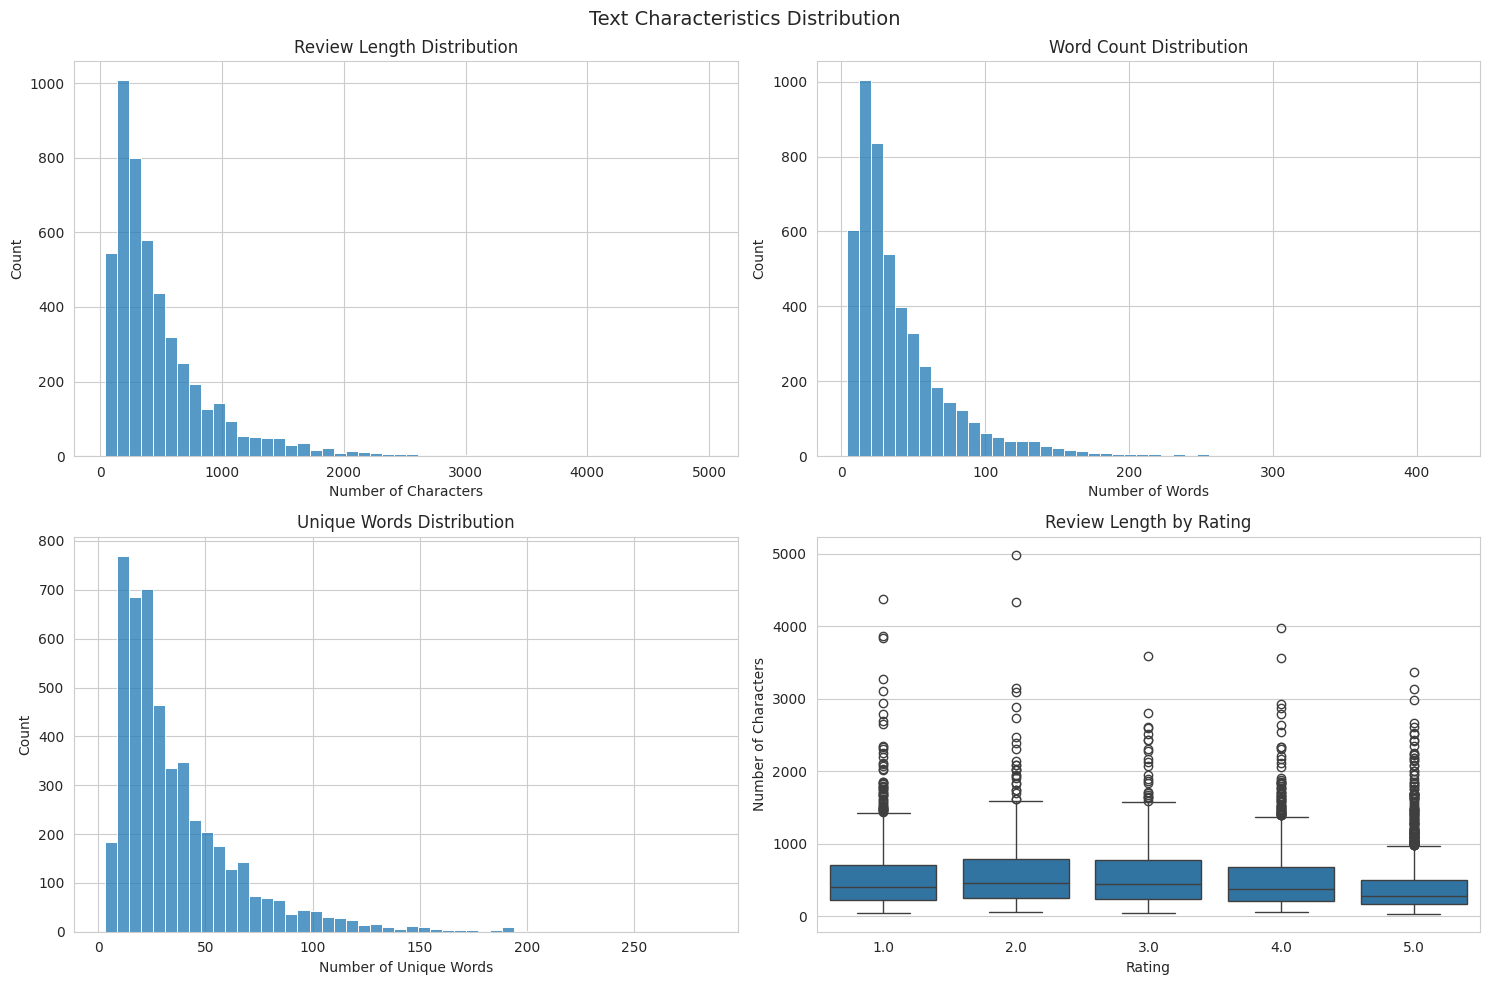

In [18]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Text Characteristics Distribution', fontsize=14)

# Review length distribution
sns.histplot(data=data_review, x='text_length', bins=50, ax=axes[0,0])
axes[0,0].set_title('Review Length Distribution')
axes[0,0].set_xlabel('Number of Characters')

# Word count distribution
sns.histplot(data=data_review, x='word_count', bins=50, ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution')
axes[0,1].set_xlabel('Number of Words')

# Unique words distribution
sns.histplot(data=data_review, x='unique_words', bins=50, ax=axes[1,0])
axes[1,0].set_title('Unique Words Distribution')
axes[1,0].set_xlabel('Number of Unique Words')

# Box plot of lengths by rating
sns.boxplot(data=data_review, x='stars', y='text_length', ax=axes[1,1])
axes[1,1].set_title('Review Length by Rating')
axes[1,1].set_xlabel('Rating')
axes[1,1].set_ylabel('Number of Characters')

plt.tight_layout()
plt.show()

### 2.1.2 Word Frequency and N-gram Analysis

In [23]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n_gram_range=(1, 1), top_k=10):
    """
    Extract top n-grams from corpus
    """
    # Create and fit vectorizer
    vectorizer = CountVectorizer(ngram_range=n_gram_range).fit(corpus)

    # If top_k is None, return all n-grams for vocabulary size calculation
    if top_k is None:
        return len(vectorizer.vocabulary_)

    # Transform corpus and get frequencies
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

In [24]:
# Get top unigrams, bigrams, and trigrams
top_unigrams = get_top_ngrams(data_review['processed_text'], (1, 1))
top_bigrams = get_top_ngrams(data_review['processed_text'], (2, 2))
top_trigrams = get_top_ngrams(data_review['processed_text'], (3, 3))

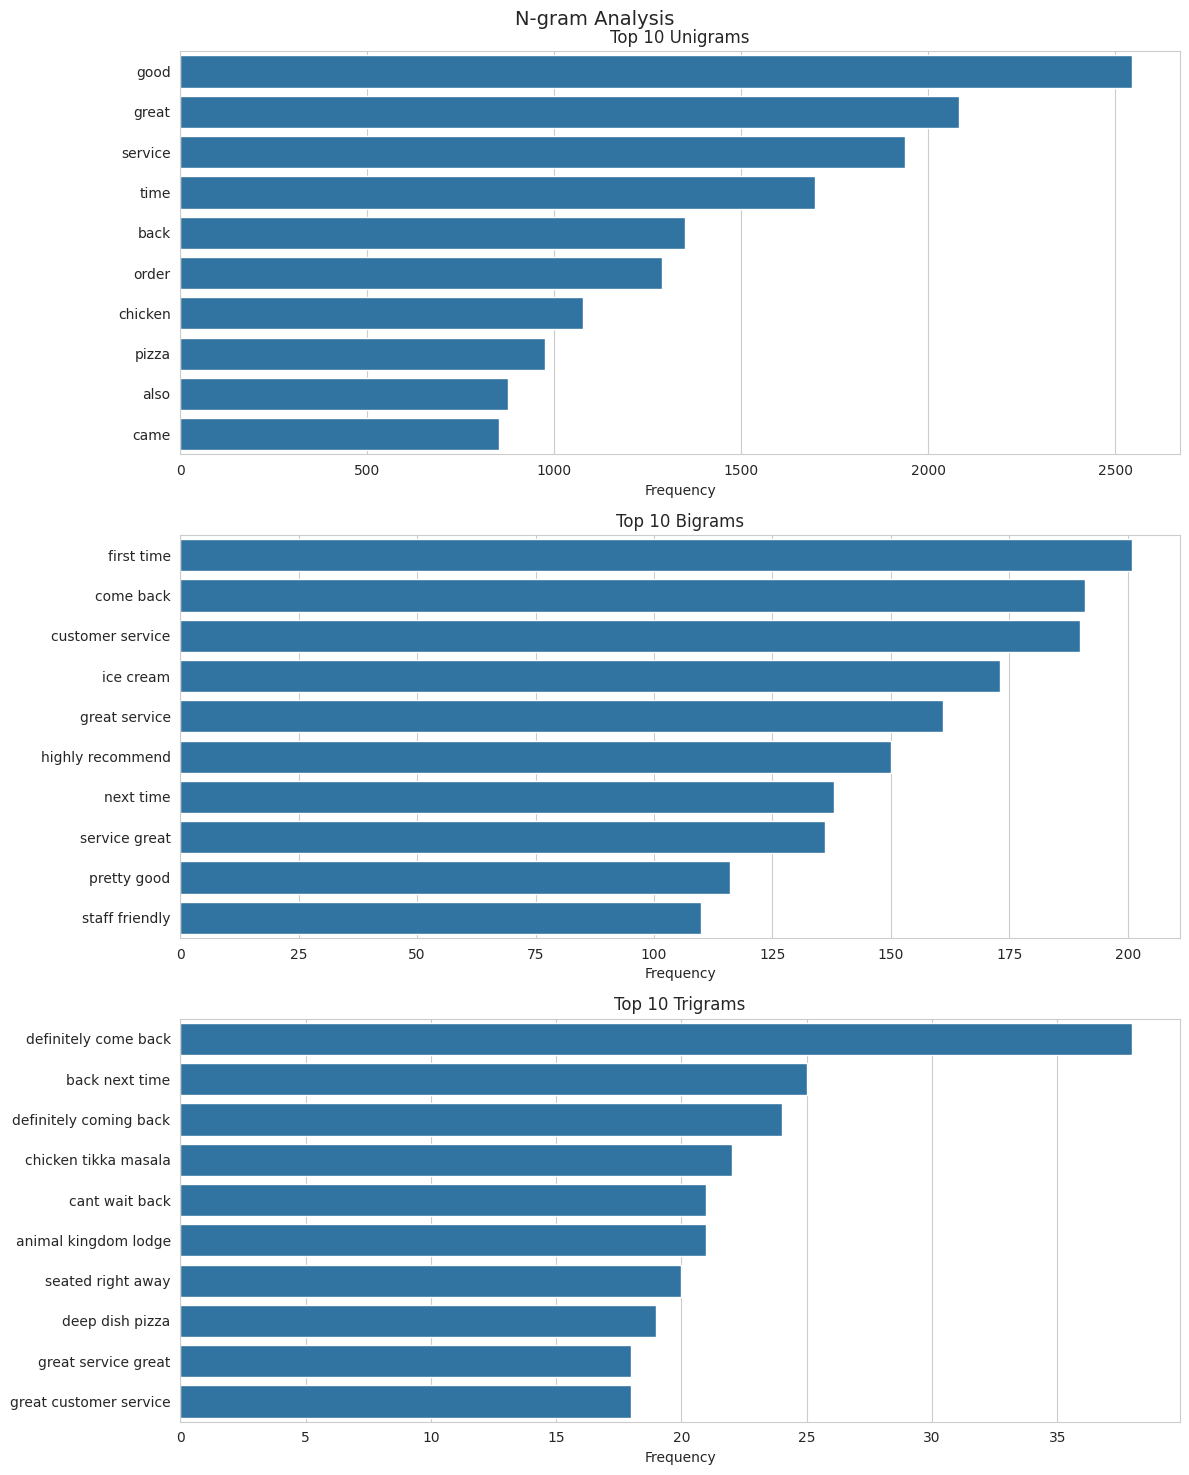

In [25]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('N-gram Analysis', fontsize=14)

# Plot unigrams
words, counts = zip(*top_unigrams)
sns.barplot(x=list(counts), y=list(words), ax=axes[0])
axes[0].set_title('Top 10 Unigrams')
axes[0].set_xlabel('Frequency')

# Plot bigrams
words, counts = zip(*top_bigrams)
sns.barplot(x=list(counts), y=list(words), ax=axes[1])
axes[1].set_title('Top 10 Bigrams')
axes[1].set_xlabel('Frequency')

# Plot trigrams
words, counts = zip(*top_trigrams)
sns.barplot(x=list(counts), y=list(words), ax=axes[2])
axes[2].set_title('Top 10 Trigrams')
axes[2].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [26]:
# Calculate vocabulary statistics
print("\nVocabulary Statistics:")
print(f"Total unique unigrams: {len(set(' '.join(data_review['processed_text']).split()))}")
print(f"Total unique bigrams: {get_top_ngrams(data_review['processed_text'], (2,2), None)}")
print(f"Total unique trigrams: {get_top_ngrams(data_review['processed_text'], (3,3), None)}")


Vocabulary Statistics:
Total unique unigrams: 12910
Total unique bigrams: 141718
Total unique trigrams: 189469


In [27]:
# Print most common n-grams
print("\nMost Common N-grams:")
print("\nTop 10 Unigrams:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

print("\nTop 10 Bigrams:")
for bigram, count in top_bigrams:
    print(f"{bigram}: {count}")

print("\nTop 10 Trigrams:")
for trigram, count in top_trigrams:
    print(f"{trigram}: {count}")


Most Common N-grams:

Top 10 Unigrams:
good: 2546
great: 2083
service: 1939
time: 1697
back: 1349
order: 1287
chicken: 1078
pizza: 974
also: 875
came: 851

Top 10 Bigrams:
first time: 201
come back: 191
customer service: 190
ice cream: 173
great service: 161
highly recommend: 150
next time: 138
service great: 136
pretty good: 116
staff friendly: 110

Top 10 Trigrams:
definitely come back: 38
back next time: 25
definitely coming back: 24
chicken tikka masala: 22
cant wait back: 21
animal kingdom lodge: 21
seated right away: 20
deep dish pizza: 19
great service great: 18
great customer service: 18


## 2.2 Preliminary Feature Analysis

### 2.2.1 TF-IDF Analysis

In [29]:
# Initialize and fit TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    max_df=0.95,  # Ignore terms that appear in more than 95% of docs
    min_df=2      # Ignore terms that appear in less than 2 docs
)
tfidf_matrix = tfidf_vectorizer.fit_transform(data_review['processed_text'])

# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Get top terms by TF-IDF score
top_tfidf_terms = sorted(zip(feature_names, tfidf_scores),
                        key=lambda x: x[1], reverse=True)[:20]

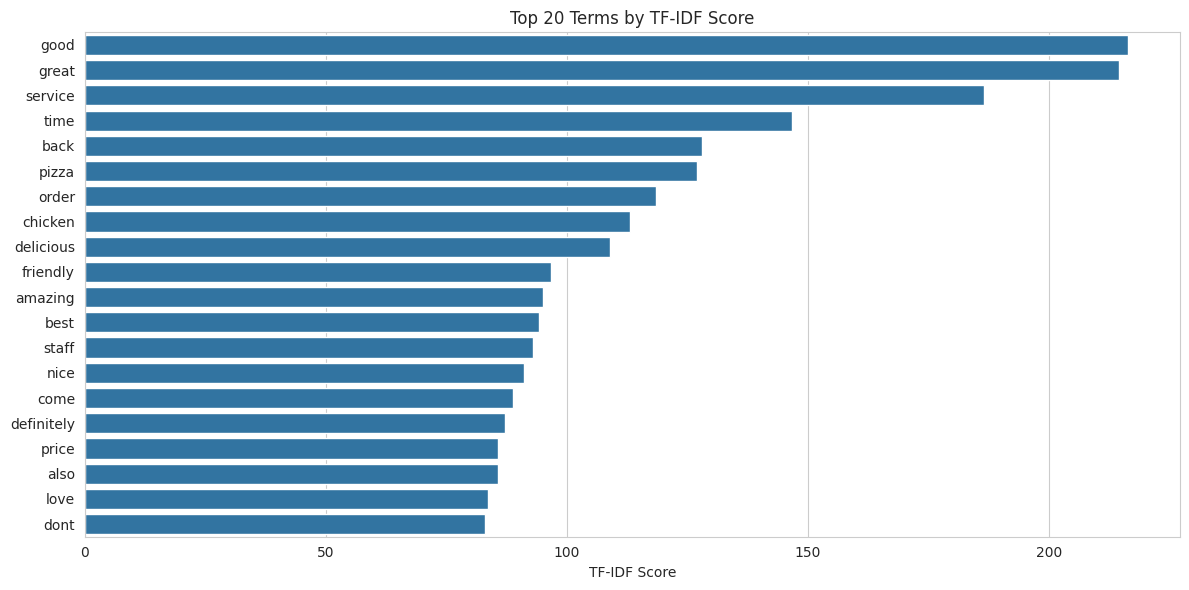

In [30]:
# Plot top TF-IDF terms
plt.figure(figsize=(12, 6))
terms, scores = zip(*top_tfidf_terms)
sns.barplot(x=list(scores), y=list(terms))
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.tight_layout()
plt.show()

In [31]:
# TF-IDF analysis by rating
print("\nTop TF-IDF terms by rating:")
for rating in range(1, 6):
    rating_docs = data_review[data_review['stars'] == rating]['processed_text']
    rating_tfidf = tfidf_vectorizer.transform(rating_docs)
    rating_scores = rating_tfidf.sum(axis=0).A1
    top_terms = sorted(zip(feature_names, rating_scores),
                      key=lambda x: x[1], reverse=True)[:5]
    print(f"\n{rating} stars:", ', '.join(term for term, score in top_terms))


Top TF-IDF terms by rating:

1 stars: order, never, service, time, minute

2 stars: service, order, good, time, didnt

3 stars: good, service, great, time, chicken

4 stars: good, great, service, pizza, time

5 stars: great, service, good, delicious, amazing


### 2.2.2 Word Clouds by Rating

In [32]:
def generate_wordcloud(text):
    return WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100,
        collocations=False
    ).generate(text)

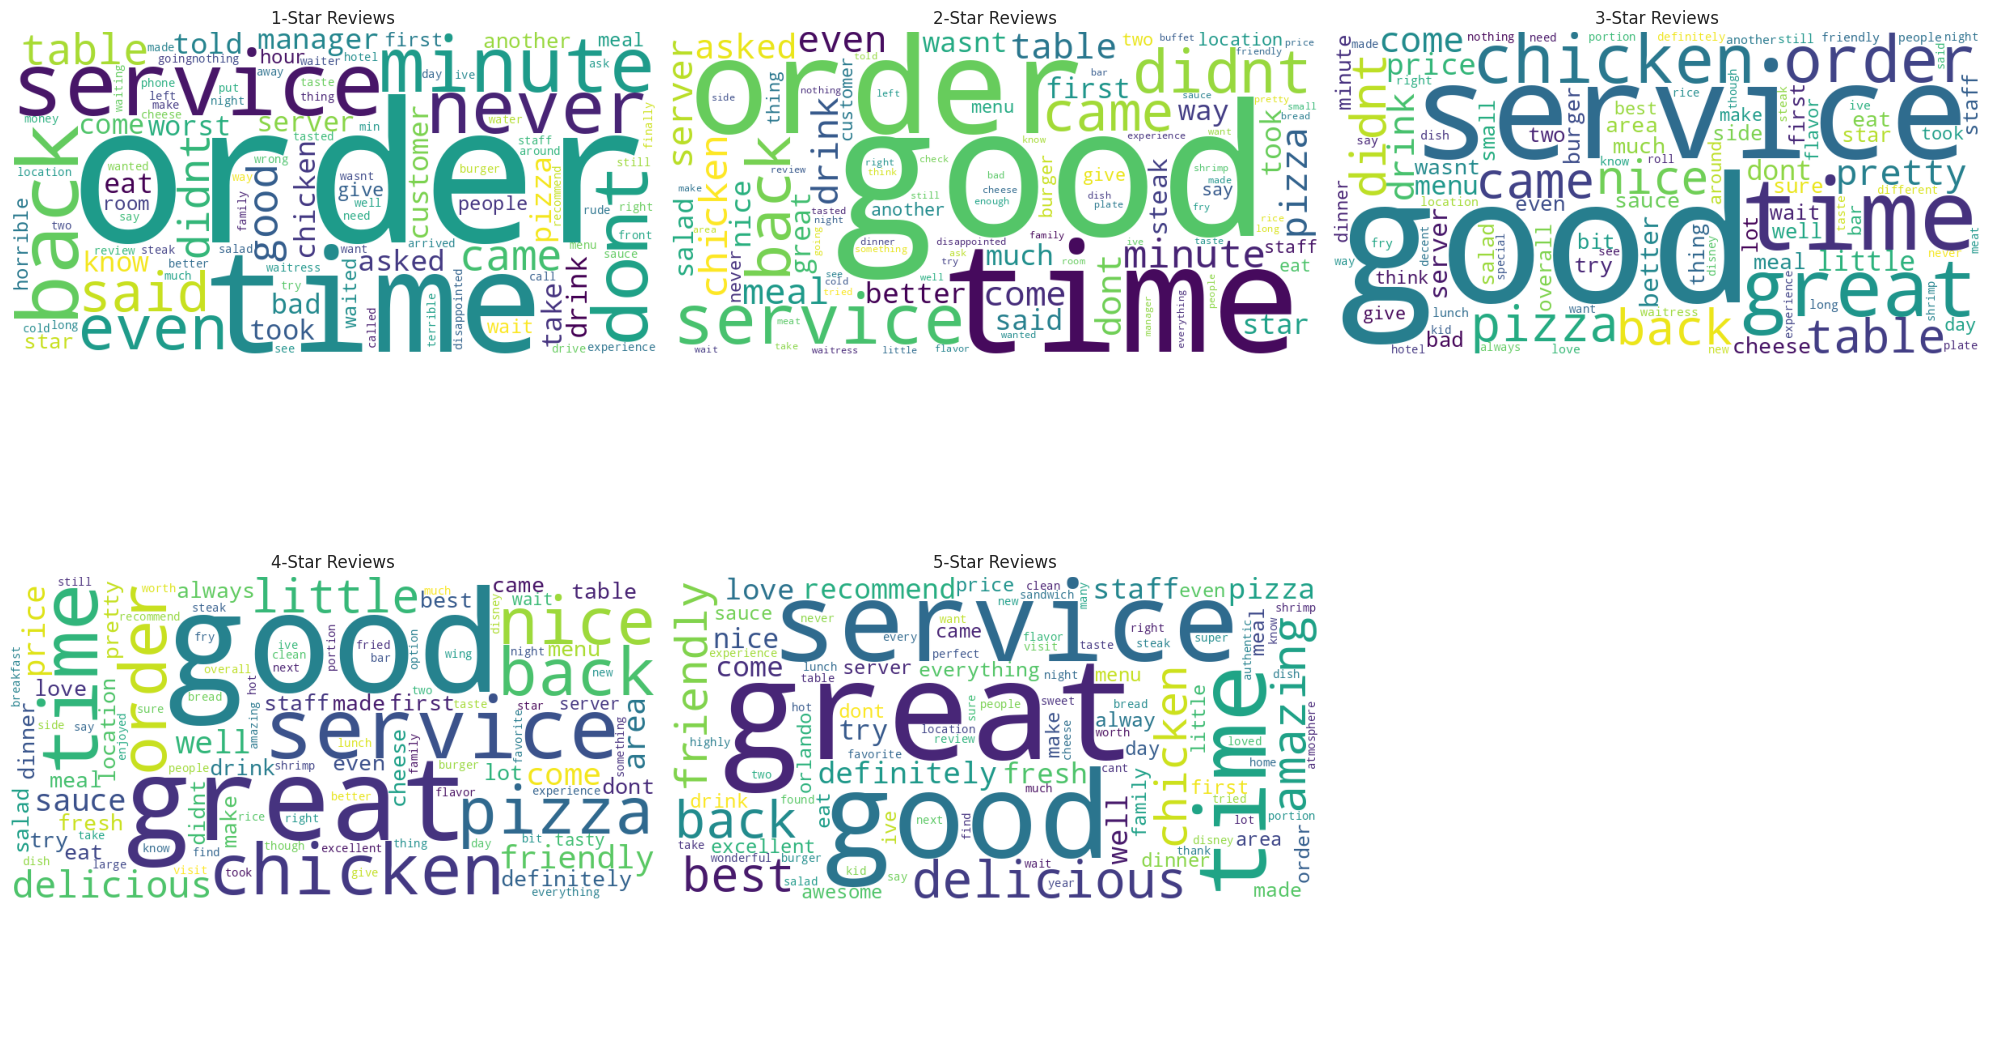

In [33]:
# Create word clouds for each rating
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for rating in range(1, 6):
    # Combine all text for this rating
    text = ' '.join(data_review[data_review['stars'] == rating]['processed_text'])

    # Generate and plot word cloud
    wordcloud = generate_wordcloud(text)
    axes[rating-1].imshow(wordcloud)
    axes[rating-1].set_title(f'{rating}-Star Reviews')
    axes[rating-1].axis('off')

axes[-1].axis('off')  # Turn off the last unused subplot
plt.tight_layout()
plt.show()

### 2.2.3 Vocabulary Overlap Analysis

In [34]:
def calculate_vocabulary_overlap(df):
    """Calculate vocabulary overlap between different ratings"""
    vocabularies = {}
    overlap_matrix = np.zeros((5, 5))

    # Get vocabulary for each rating
    for rating in range(1, 6):
        texts = df[df['stars'] == rating]['processed_text']
        vocabularies[rating] = set(' '.join(texts).split())

    # Calculate Jaccard similarity
    for i in range(1, 6):
        for j in range(1, 6):
            intersection = len(vocabularies[i] & vocabularies[j])
            union = len(vocabularies[i] | vocabularies[j])
            overlap_matrix[i-1, j-1] = intersection / union

    return overlap_matrix

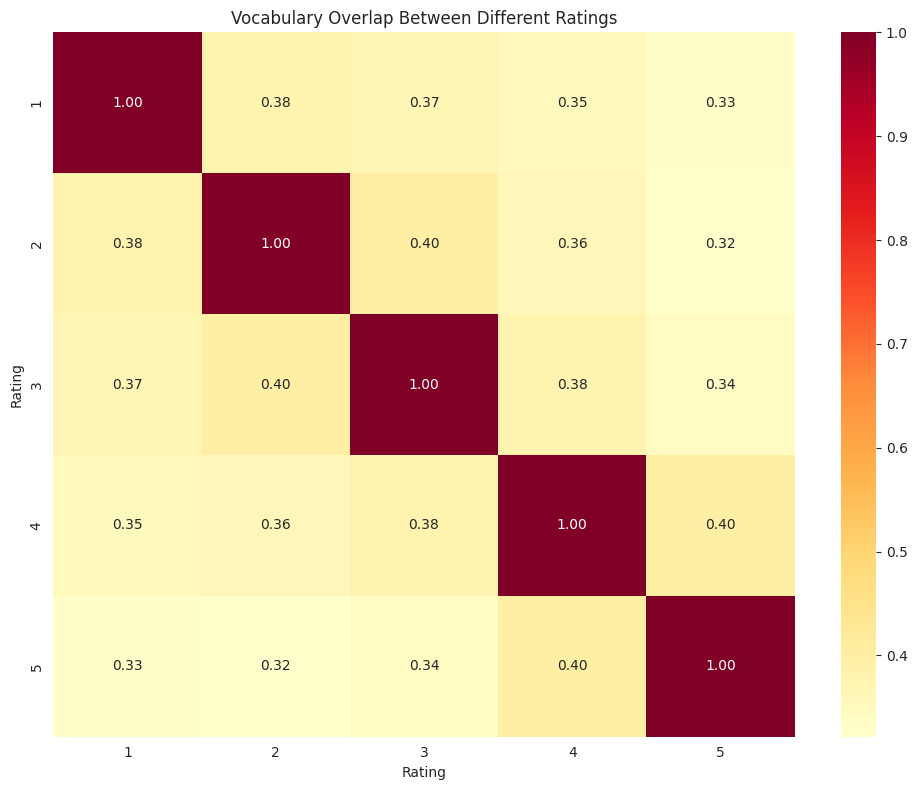

In [35]:
# Calculate and visualize vocabulary overlap
overlap_matrix = calculate_vocabulary_overlap(data_review)

plt.figure(figsize=(10, 8))
sns.heatmap(
    overlap_matrix,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=range(1, 6),
    yticklabels=range(1, 6)
)
plt.title('Vocabulary Overlap Between Different Ratings')
plt.xlabel('Rating')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

In [36]:
# Print summary statistics
print("\nVocabulary Overlap Summary:")
print(f"Average overlap between consecutive ratings: {np.mean([overlap_matrix[i,i+1] for i in range(4)]):.3f}")
print(f"Overlap between 1-star and 5-star reviews: {overlap_matrix[0,4]:.3f}")


Vocabulary Overlap Summary:
Average overlap between consecutive ratings: 0.388
Overlap between 1-star and 5-star reviews: 0.328


### 2.2.4 Document Length Analysis by Rating

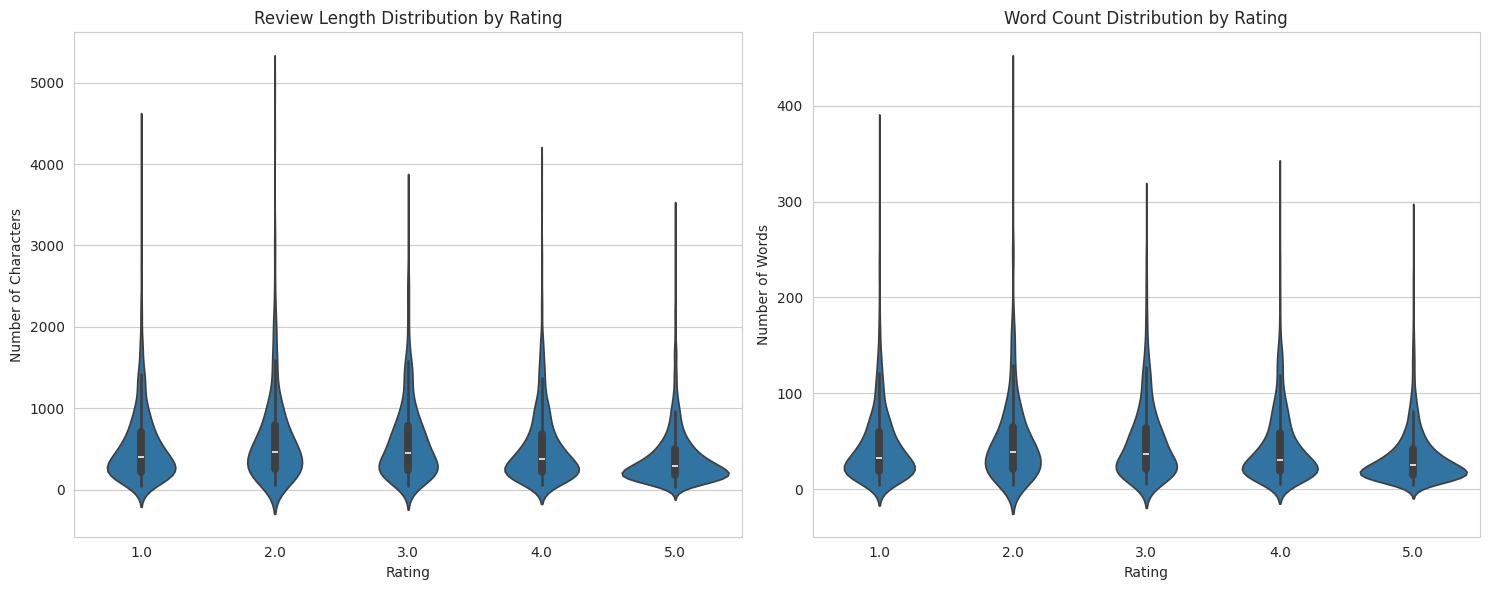

In [37]:
# Create violin plots for document lengths by rating
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Character length distribution
sns.violinplot(data=data_review, x='stars', y='text_length', ax=ax1)
ax1.set_title('Review Length Distribution by Rating')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Number of Characters')

# Word count distribution
sns.violinplot(data=data_review, x='stars', y='word_count', ax=ax2)
ax2.set_title('Word Count Distribution by Rating')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

In [38]:
# Print summary statistics by rating
print("\nLength Statistics by Rating:")
length_stats = data_review.groupby('stars').agg({
    'text_length': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std']
}).round(2)
display(length_stats)


Length Statistics by Rating:


text_length                word_count              
             mean median     std       mean median    std
stars                                                    
1.0        552.77  398.0  498.92      45.99   33.0  40.90
2.0        628.00  460.0  586.34      52.34   39.0  49.29
3.0        601.31  452.5  499.59      50.66   37.0  42.25
4.0        526.99  379.0  463.77      45.35   31.0  39.70
5.0        402.25  286.0  369.08      34.64   25.0  31.49

# SECTION 3: TOPIC MODELING IMPLEMENTATION

## 3.1 LDA Implementation

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import numpy as np
from tqdm import tqdm

print("Creating document-term matrix...")

# Create document-term matrix using CountVectorizer
count_vectorizer = CountVectorizer(
    max_df=0.95,         # Remove terms that appear in >95% of docs
    min_df=2,            # Remove terms that appear in <2 documents
    stop_words='english',
    max_features=5000    # Limit vocabulary size
)

# Fit and transform the data
doc_term_matrix = count_vectorizer.fit_transform(data_review['processed_text'])
feature_names = count_vectorizer.get_feature_names_out()

print("Document-term matrix shape:", doc_term_matrix.shape)
print("Vocabulary size:", len(feature_names))

Creating document-term matrix...
Document-term matrix shape: (4885, 5000)
Vocabulary size: 5000


### 3.1.1 LDA Topic Number Optimization

In [42]:
def evaluate_lda_model(n_topics):
    """Evaluate LDA model with given number of topics"""
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        learning_method='online',
        learning_offset=50.,
        n_jobs=-1
    )

    # Fit the model and measure time
    lda.fit(doc_term_matrix)

    # Calculate perplexity
    perplexity = lda.perplexity(doc_term_matrix)

    # Calculate log likelihood
    log_likelihood = lda.score(doc_term_matrix)

    return perplexity, log_likelihood

In [43]:
# Test different numbers of topics
n_topics_range = range(2, 21, 2)
perplexities = []
likelihoods = []

print("Evaluating different numbers of topics...")
for n_topics in tqdm(n_topics_range):
    perplexity, likelihood = evaluate_lda_model(n_topics)
    perplexities.append(perplexity)
    likelihoods.append(likelihood)

Evaluating different numbers of topics...


100%|██████████| 10/10 [06:44<00:00, 40.50s/it]


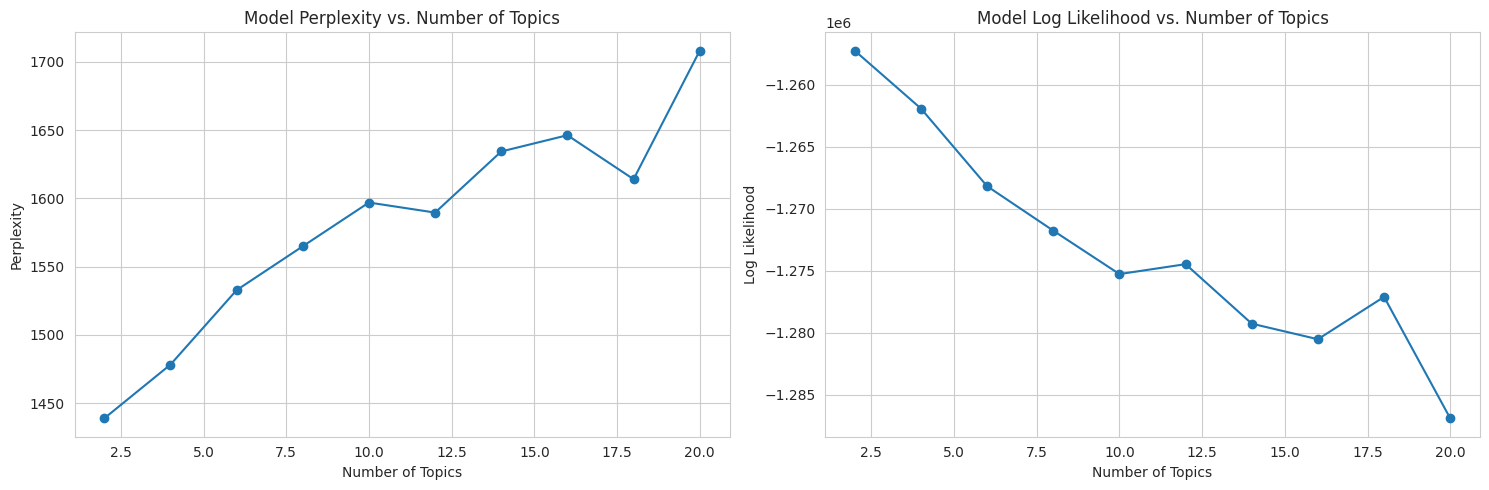

In [44]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(n_topics_range, perplexities, marker='o')
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Perplexity")
ax1.set_title("Model Perplexity vs. Number of Topics")

ax2.plot(n_topics_range, likelihoods, marker='o')
ax2.set_xlabel("Number of Topics")
ax2.set_ylabel("Log Likelihood")
ax2.set_title("Model Log Likelihood vs. Number of Topics")

plt.tight_layout()
plt.show()

### 3.1.2 Train Final LDA Model

In [45]:
optimal_topics = 10

# Train final LDA model
final_lda = LatentDirichletAllocation(
    n_components=optimal_topics,
    random_state=42,
    max_iter=20,
    learning_method='online',
    learning_offset=50.,
    n_jobs=-1
)

print("Training final LDA model...")
final_lda.fit(doc_term_matrix)

Training final LDA model...


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=20, n_jobs=-1, random_state=42)

In [46]:
# Function to print top words per topic
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx + 1}:")
        print(", ".join(top_words))
        print()

print("\nTop words in each topic:")
print_topics(final_lda, feature_names)


Top words in each topic:
Topic 1:
course, play, hole, club, golf, playing, cart, green, played, tee

Topic 2:
filipino, market, kabayan, exceeds, pancit, lechon, bangus, sinigang, grille, san

Topic 3:
german, carne, que, scale, asada, hospitable, danielle, kiss, comida, frita

Topic 4:
great, good, pizza, delicious, service, friendly, price, fresh, burger, staff

Topic 5:
good, great, service, chicken, sauce, meal, delicious, best, nice, steak

Topic 6:
fun, king, knight, medieval, ticket, entertainment, utensil, horse, event, dad

Topic 7:
ultra, ease, western, coolest, preparation, cowboy, appear, struggling, gold, easier

Topic 8:
chipotle, miller, tijuana, update, ownership, bee, doughnut, bitch, zuppa, sweat

Topic 9:
time, service, order, good, came, table, server, didnt, dont, drink

Topic 10:
order, room, pizza, hotel, minute, said, called, told, phone, time



In [47]:
# Get document-topic distributions
doc_topics = final_lda.transform(doc_term_matrix)

# Add dominant topic to dataframe
data_review['dominant_topic'] = doc_topics.argmax(axis=1)

## 3.2 Alternative Topic Models

In [48]:
# Prepare TF-IDF matrix for NMF and LSA
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2,
    stop_words='english',
    max_features=5000
)
tfidf_matrix = tfidf_vectorizer.fit_transform(data_review['processed_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [49]:
# Train NMF model
print("Training NMF model...")
nmf_model = NMF(
    n_components=optimal_topics,
    random_state=42,
    max_iter=200
)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Train LSA model
print("\nTraining LSA model...")
lsa_model = TruncatedSVD(
    n_components=optimal_topics,
    random_state=42
)
lsa_topics = lsa_model.fit_transform(tfidf_matrix)

Training NMF model...

Training LSA model...


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [50]:
# Print topics for each model
print("\nNMF Topics:")
print_topics(nmf_model, tfidf_feature_names)

print("\nLSA Topics:")
def print_lsa_topics(model, feature_names, n_top_words=10):
    for topic_idx, comp in enumerate(model.components_):
        top_words_idx = comp.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx + 1}:")
        print(", ".join(top_words))
        print()

print_lsa_topics(lsa_model, tfidf_feature_names)


NMF Topics:
Topic 1:
table, drink, server, came, steak, meal, didnt, waitress, wait, dinner

Topic 2:
pizza, crust, cheese, delivery, topping, pepperoni, salad, chicago, wing, garlic

Topic 3:
order, time, minute, customer, service, took, dont, location, waited, manager

Topic 4:
chicken, sauce, rice, flavor, fried, salad, spicy, soup, beef, bread

Topic 5:
good, price, service, pretty, nice, sushi, little, portion, overall, bit

Topic 6:
burger, fry, onion, cheese, shula, ring, bacon, french, taste, cooked

Topic 7:
friendly, staff, clean, nice, location, breakfast, coffee, love, super, fresh

Topic 8:
amazing, definitely, best, delicious, recommend, service, excellent, highly, orlando, ive

Topic 9:
ice, cream, make, cone, love, serve, fun, super, flavor, kid

Topic 10:
great, service, price, atmosphere, excellent, time, selection, fun, love, awesome


LSA Topics:
Topic 1:
great, good, service, time, pizza, order, chicken, delicious, friendly, come

Topic 2:
pizza, crust, order, che

## 3.3 Model Comparison and Evaluation

In [51]:
def calculate_topic_diversity(model, feature_names, n_top_words=20):
    """Calculate topic diversity based on unique words in top N words per topic"""
    all_top_words = set()
    total_words = 0

    for topic in model.components_:
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        all_top_words.update(top_words)
        total_words += n_top_words

    return len(all_top_words) / total_words

In [52]:
# Calculate topic diversity for each model
lda_diversity = calculate_topic_diversity(final_lda, feature_names)
nmf_diversity = calculate_topic_diversity(nmf_model, tfidf_feature_names)
lsa_diversity = calculate_topic_diversity(lsa_model, tfidf_feature_names)

print("Topic Diversity Scores:")
print(f"LDA: {lda_diversity:.3f}")
print(f"NMF: {nmf_diversity:.3f}")
print(f"LSA: {lsa_diversity:.3f}")

Topic Diversity Scores:
LDA: 0.895
NMF: 0.795
LSA: 0.510


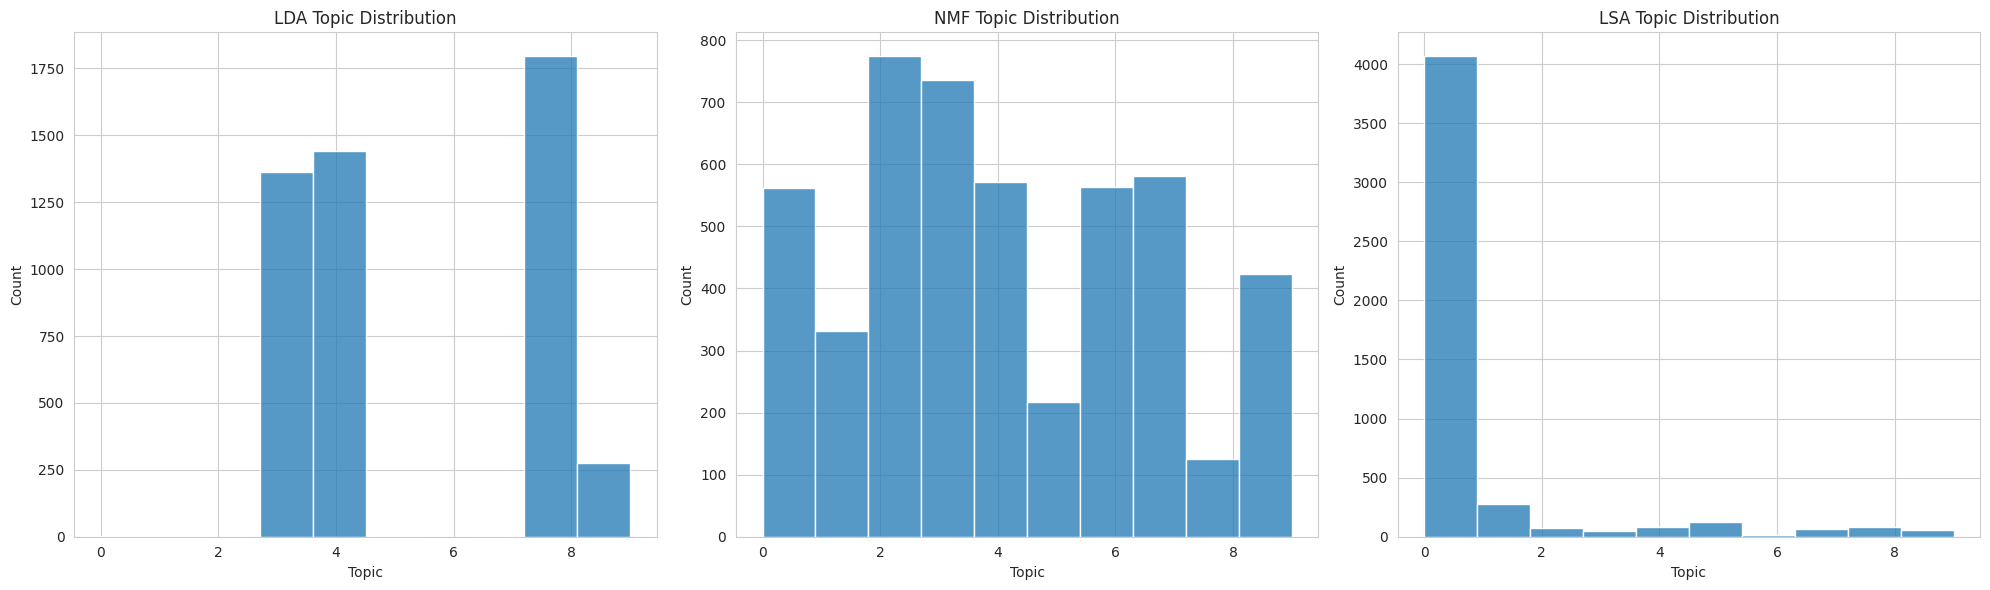

In [53]:
# Visualize topic distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# LDA
sns.histplot(data=data_review, x='dominant_topic', bins=optimal_topics, ax=axes[0])
axes[0].set_title('LDA Topic Distribution')
axes[0].set_xlabel('Topic')

# NMF
dominant_nmf_topics = nmf_topics.argmax(axis=1)
sns.histplot(x=dominant_nmf_topics, bins=optimal_topics, ax=axes[1])
axes[1].set_title('NMF Topic Distribution')
axes[1].set_xlabel('Topic')

# LSA
dominant_lsa_topics = lsa_topics.argmax(axis=1)
sns.histplot(x=dominant_lsa_topics, bins=optimal_topics, ax=axes[2])
axes[2].set_title('LSA Topic Distribution')
axes[2].set_xlabel('Topic')

plt.tight_layout()
plt.show()

## 3.4 Topic Coherence Analysis

In [54]:
def calculate_coherence_score(model, texts):
    """Calculate topic coherence score"""
    # Prepare corpus for coherence calculation
    processed_docs = [doc.split() for doc in texts]
    dictionary = Dictionary(processed_docs)
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    # Extract topics in required format
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-10-1:-1]
        topics.append([feature_names[i] for i in top_words_idx])

    # Calculate coherence
    coherence_model = CoherenceModel(
        topics=topics,
        texts=processed_docs,
        dictionary=dictionary,
        coherence='c_v'
    )

    return coherence_model.get_coherence()

In [55]:
# Calculate coherence scores
print("Calculating coherence scores...")
lda_coherence = calculate_coherence_score(final_lda, data_review['processed_text'])
nmf_coherence = calculate_coherence_score(nmf_model, data_review['processed_text'])
lsa_coherence = calculate_coherence_score(lsa_model, data_review['processed_text'])

print("\nCoherence Scores:")
print(f"LDA: {lda_coherence:.3f}")
print(f"NMF: {nmf_coherence:.3f}")
print(f"LSA: {lsa_coherence:.3f}")

Calculating coherence scores...

Coherence Scores:
LDA: 0.513
NMF: 0.512
LSA: 0.445


## 3.5 Enhanced Model Evaluation

In [64]:
!pip install --quiet pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
# 3.5 Enhanced Model Evaluation

import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

def calculate_topic_metrics(model, doc_topic_dist, feature_names):
    """
    Calculate various topic model evaluation metrics
    """
    metrics = {}

    # Topic concentration (measure of how concentrated documents are in topics)
    topic_concentration = np.mean([max(dist) for dist in doc_topic_dist])
    metrics['topic_concentration'] = topic_concentration

    # Topic diversity (unique words in top terms)
    n_top_words = 20
    unique_top_words = set()
    for topic in model.components_:
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        unique_top_words.update([feature_names[i] for i in top_words_idx])
    metrics['topic_diversity'] = len(unique_top_words) / (n_top_words * model.n_components)

    # Mean topic coherence
    topic_coherences = []
    for topic in model.components_:
        top_terms_idx = topic.argsort()[:-10-1:-1]
        topic_terms = [feature_names[i] for i in top_terms_idx]
        # Calculate PMI-based coherence
        topic_coherences.append(calculate_pmi_coherence(topic_terms, doc_term_matrix, count_vectorizer))
    metrics['mean_coherence'] = np.mean(topic_coherences)

    return metrics

def calculate_pmi_coherence(topic_terms, dtm, vectorizer):
    """
    Calculate PMI-based coherence for a topic
    """
    term_indices = [vectorizer.vocabulary_[term] for term in topic_terms if term in vectorizer.vocabulary_]
    co_doc_matrix = (dtm[:, term_indices] > 0).astype(int)
    term_freq = co_doc_matrix.sum(axis=0).A1
    term_co_freq = co_doc_matrix.T @ co_doc_matrix

    n_docs = dtm.shape[0]
    pmi_scores = []

    for i in range(len(term_indices)):
        for j in range(i+1, len(term_indices)):
            if term_freq[i] > 0 and term_freq[j] > 0:
                pmi = np.log((term_co_freq[i,j] * n_docs) /
                           (term_freq[i] * term_freq[j]))
                pmi_scores.append(pmi)

    return np.mean(pmi_scores) if pmi_scores else 0



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# Calculate metrics for all models
print("Calculating evaluation metrics...")
models = {
    'LDA': (final_lda, final_lda.transform(doc_term_matrix), feature_names),
    'NMF': (nmf_model, nmf_topics, tfidf_feature_names),
    'LSA': (lsa_model, lsa_topics, tfidf_feature_names)
}

for model_name, (model, doc_topics, feat_names) in models.items():
    metrics = calculate_topic_metrics(model, doc_topics, feat_names)
    print(f"\n{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

Calculating evaluation metrics...

LDA Metrics:
topic_concentration: 0.690
topic_diversity: 0.895
mean_coherence: -inf

NMF Metrics:
topic_concentration: 0.079
topic_diversity: 0.795
mean_coherence: -inf

LSA Metrics:
topic_concentration: 0.170
topic_diversity: 0.510
mean_coherence: 0.354


## 3.6 Topic Similarity Analysis

In [67]:
# 3.6 Topic Similarity Analysis

def calculate_topic_similarities(model, feature_names):
    """
    Calculate similarities between topics using cosine similarity
    """
    # Normalize topic-word distributions
    topic_word_dist = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # Calculate cosine similarities
    similarities = 1 - cdist(topic_word_dist, topic_word_dist, metric='cosine')
    return similarities

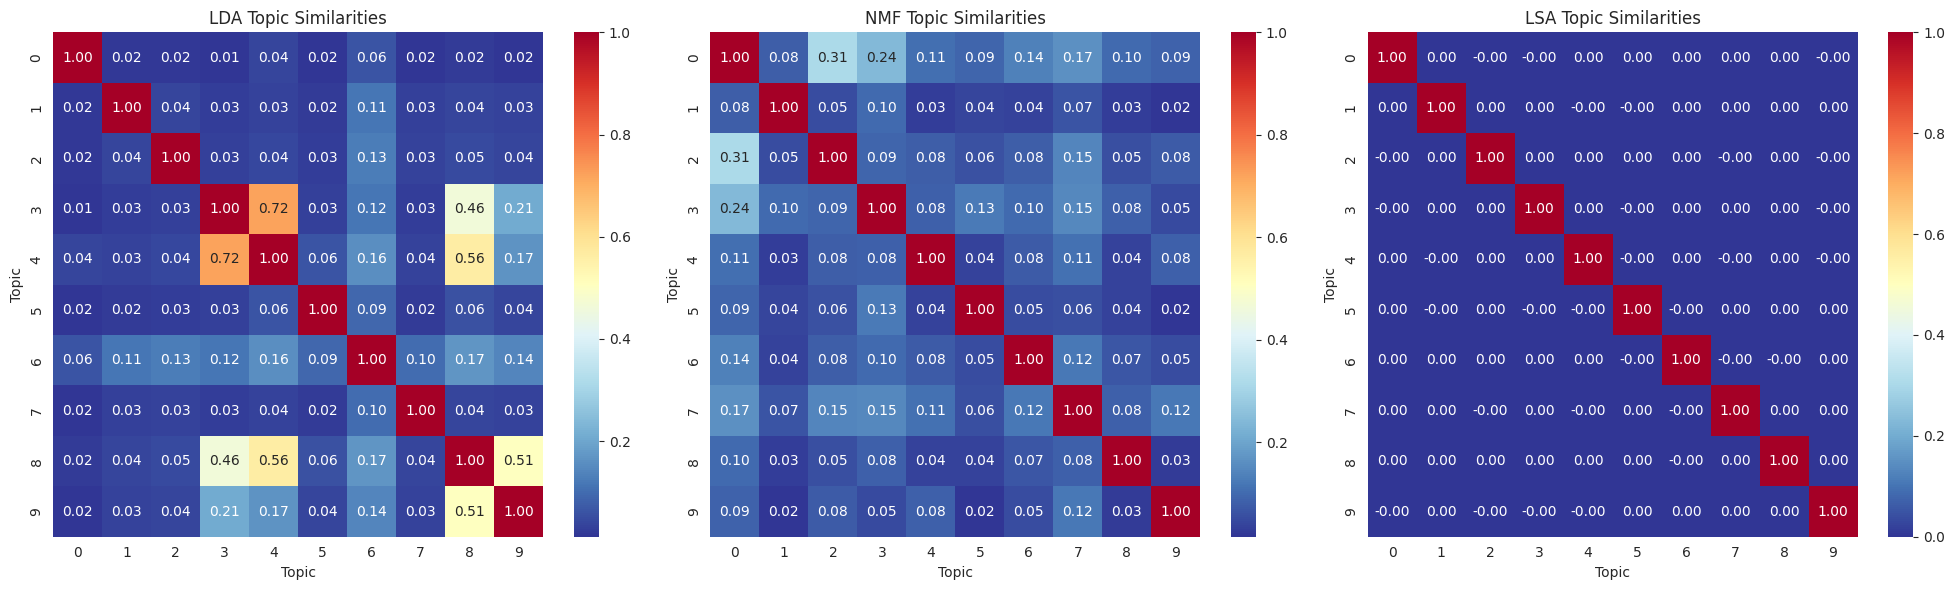

In [68]:
# Calculate and visualize topic similarities for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (model_name, (model, _, feat_names)) in enumerate(models.items()):
    similarities = calculate_topic_similarities(model, feat_names)

    sns.heatmap(similarities,
                annot=True,
                cmap='RdYlBu_r',
                ax=axes[idx],
                fmt='.2f')
    axes[idx].set_title(f'{model_name} Topic Similarities')
    axes[idx].set_xlabel('Topic')
    axes[idx].set_ylabel('Topic')

plt.tight_layout()
plt.show()

## 3.7 Topic Stability Analysis

In [69]:
from sklearn.model_selection import KFold

def assess_topic_stability(model_class, doc_term_matrix, n_folds=5):
    """
    Assess topic stability using cross-validation
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    jaccard_similarities = []

    base_model = model_class(
        n_components=optimal_topics,
        random_state=42
    ).fit(doc_term_matrix)

    base_topics = []
    for topic in base_model.components_:
        top_words_idx = topic.argsort()[:-10-1:-1]
        base_topics.append(set(feature_names[i] for i in top_words_idx))

    for train_idx, val_idx in kf.split(doc_term_matrix):
        # Train model on fold
        fold_model = model_class(
            n_components=optimal_topics,
            random_state=42
        ).fit(doc_term_matrix[train_idx])

        # Get topics
        fold_topics = []
        for topic in fold_model.components_:
            top_words_idx = topic.argsort()[:-10-1:-1]
            fold_topics.append(set(feature_names[i] for i in top_words_idx))

        # Calculate Jaccard similarities
        similarities = []
        for base_topic in base_topics:
            max_similarity = max(len(base_topic & fold_topic) / len(base_topic | fold_topic)
                               for fold_topic in fold_topics)
            similarities.append(max_similarity)

        jaccard_similarities.append(np.mean(similarities))

    return np.mean(jaccard_similarities), np.std(jaccard_similarities)

In [70]:
# Calculate stability for each model
print("Assessing topic stability...")
for model_name, model_class in [
    ('LDA', LatentDirichletAllocation),
    ('NMF', NMF),
    ('LSA', TruncatedSVD)
]:
    mean_stability, std_stability = assess_topic_stability(model_class, doc_term_matrix)
    print(f"\n{model_name} Topic Stability:")
    print(f"Mean Jaccard Similarity: {mean_stability:.3f} (±{std_stability:.3f})")

Assessing topic stability...

LDA Topic Stability:
Mean Jaccard Similarity: 0.627 (±0.021)

NMF Topic Stability:
Mean Jaccard Similarity: 0.712 (±0.072)

LSA Topic Stability:
Mean Jaccard Similarity: 0.684 (±0.070)


## 3.8 Cross-validation Analysis

In [71]:
def cross_validate_topic_model(model_class, doc_term_matrix, n_folds=5):
    """
    Perform cross-validation for topic models
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = {
        'perplexity': [],
        'coherence': [],
        'topic_diversity': []
    }

    for train_idx, val_idx in tqdm(kf.split(doc_term_matrix), total=n_folds):
        # Train model
        model = model_class(
            n_components=optimal_topics,
            random_state=42
        ).fit(doc_term_matrix[train_idx])

        # Calculate metrics
        if hasattr(model, 'perplexity_'):
            perp = model.perplexity(doc_term_matrix[val_idx])
            scores['perplexity'].append(perp)

        # Calculate topic diversity
        n_top_words = 20
        unique_words = set()
        total_words = 0
        for topic in model.components_:
            top_words_idx = topic.argsort()[:-n_top_words-1:-1]
            unique_words.update(feature_names[i] for i in top_words_idx)
            total_words += n_top_words
        diversity = len(unique_words) / total_words
        scores['topic_diversity'].append(diversity)

        # Calculate coherence
        coherence = calculate_coherence_score(model, data_review['processed_text'].iloc[val_idx])
        scores['coherence'].append(coherence)

    return {k: (np.mean(v), np.std(v)) for k, v in scores.items()}

In [72]:
print("Performing cross-validation...")
for model_name, model_class in [
    ('LDA', LatentDirichletAllocation),
    ('NMF', NMF),
    ('LSA', TruncatedSVD)
]:
    cv_scores = cross_validate_topic_model(model_class, doc_term_matrix)
    print(f"\n{model_name} Cross-validation Results:")
    for metric, (mean, std) in cv_scores.items():
        print(f"{metric}: {mean:.3f} (±{std:.3f})")

Performing cross-validation...


100%|██████████| 5/5 [01:39<00:00, 19.99s/it]



LDA Cross-validation Results:
perplexity: nan (±nan)
coherence: 0.388 (±0.018)
topic_diversity: 0.582 (±0.022)


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]



NMF Cross-validation Results:
perplexity: nan (±nan)
coherence: 0.419 (±0.013)
topic_diversity: 0.668 (±0.013)


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


LSA Cross-validation Results:
perplexity: nan (±nan)
coherence: 0.383 (±0.016)
topic_diversity: 0.502 (±0.020)


## 3.9 Topic Visualization


LDA Topic-Term Importance:


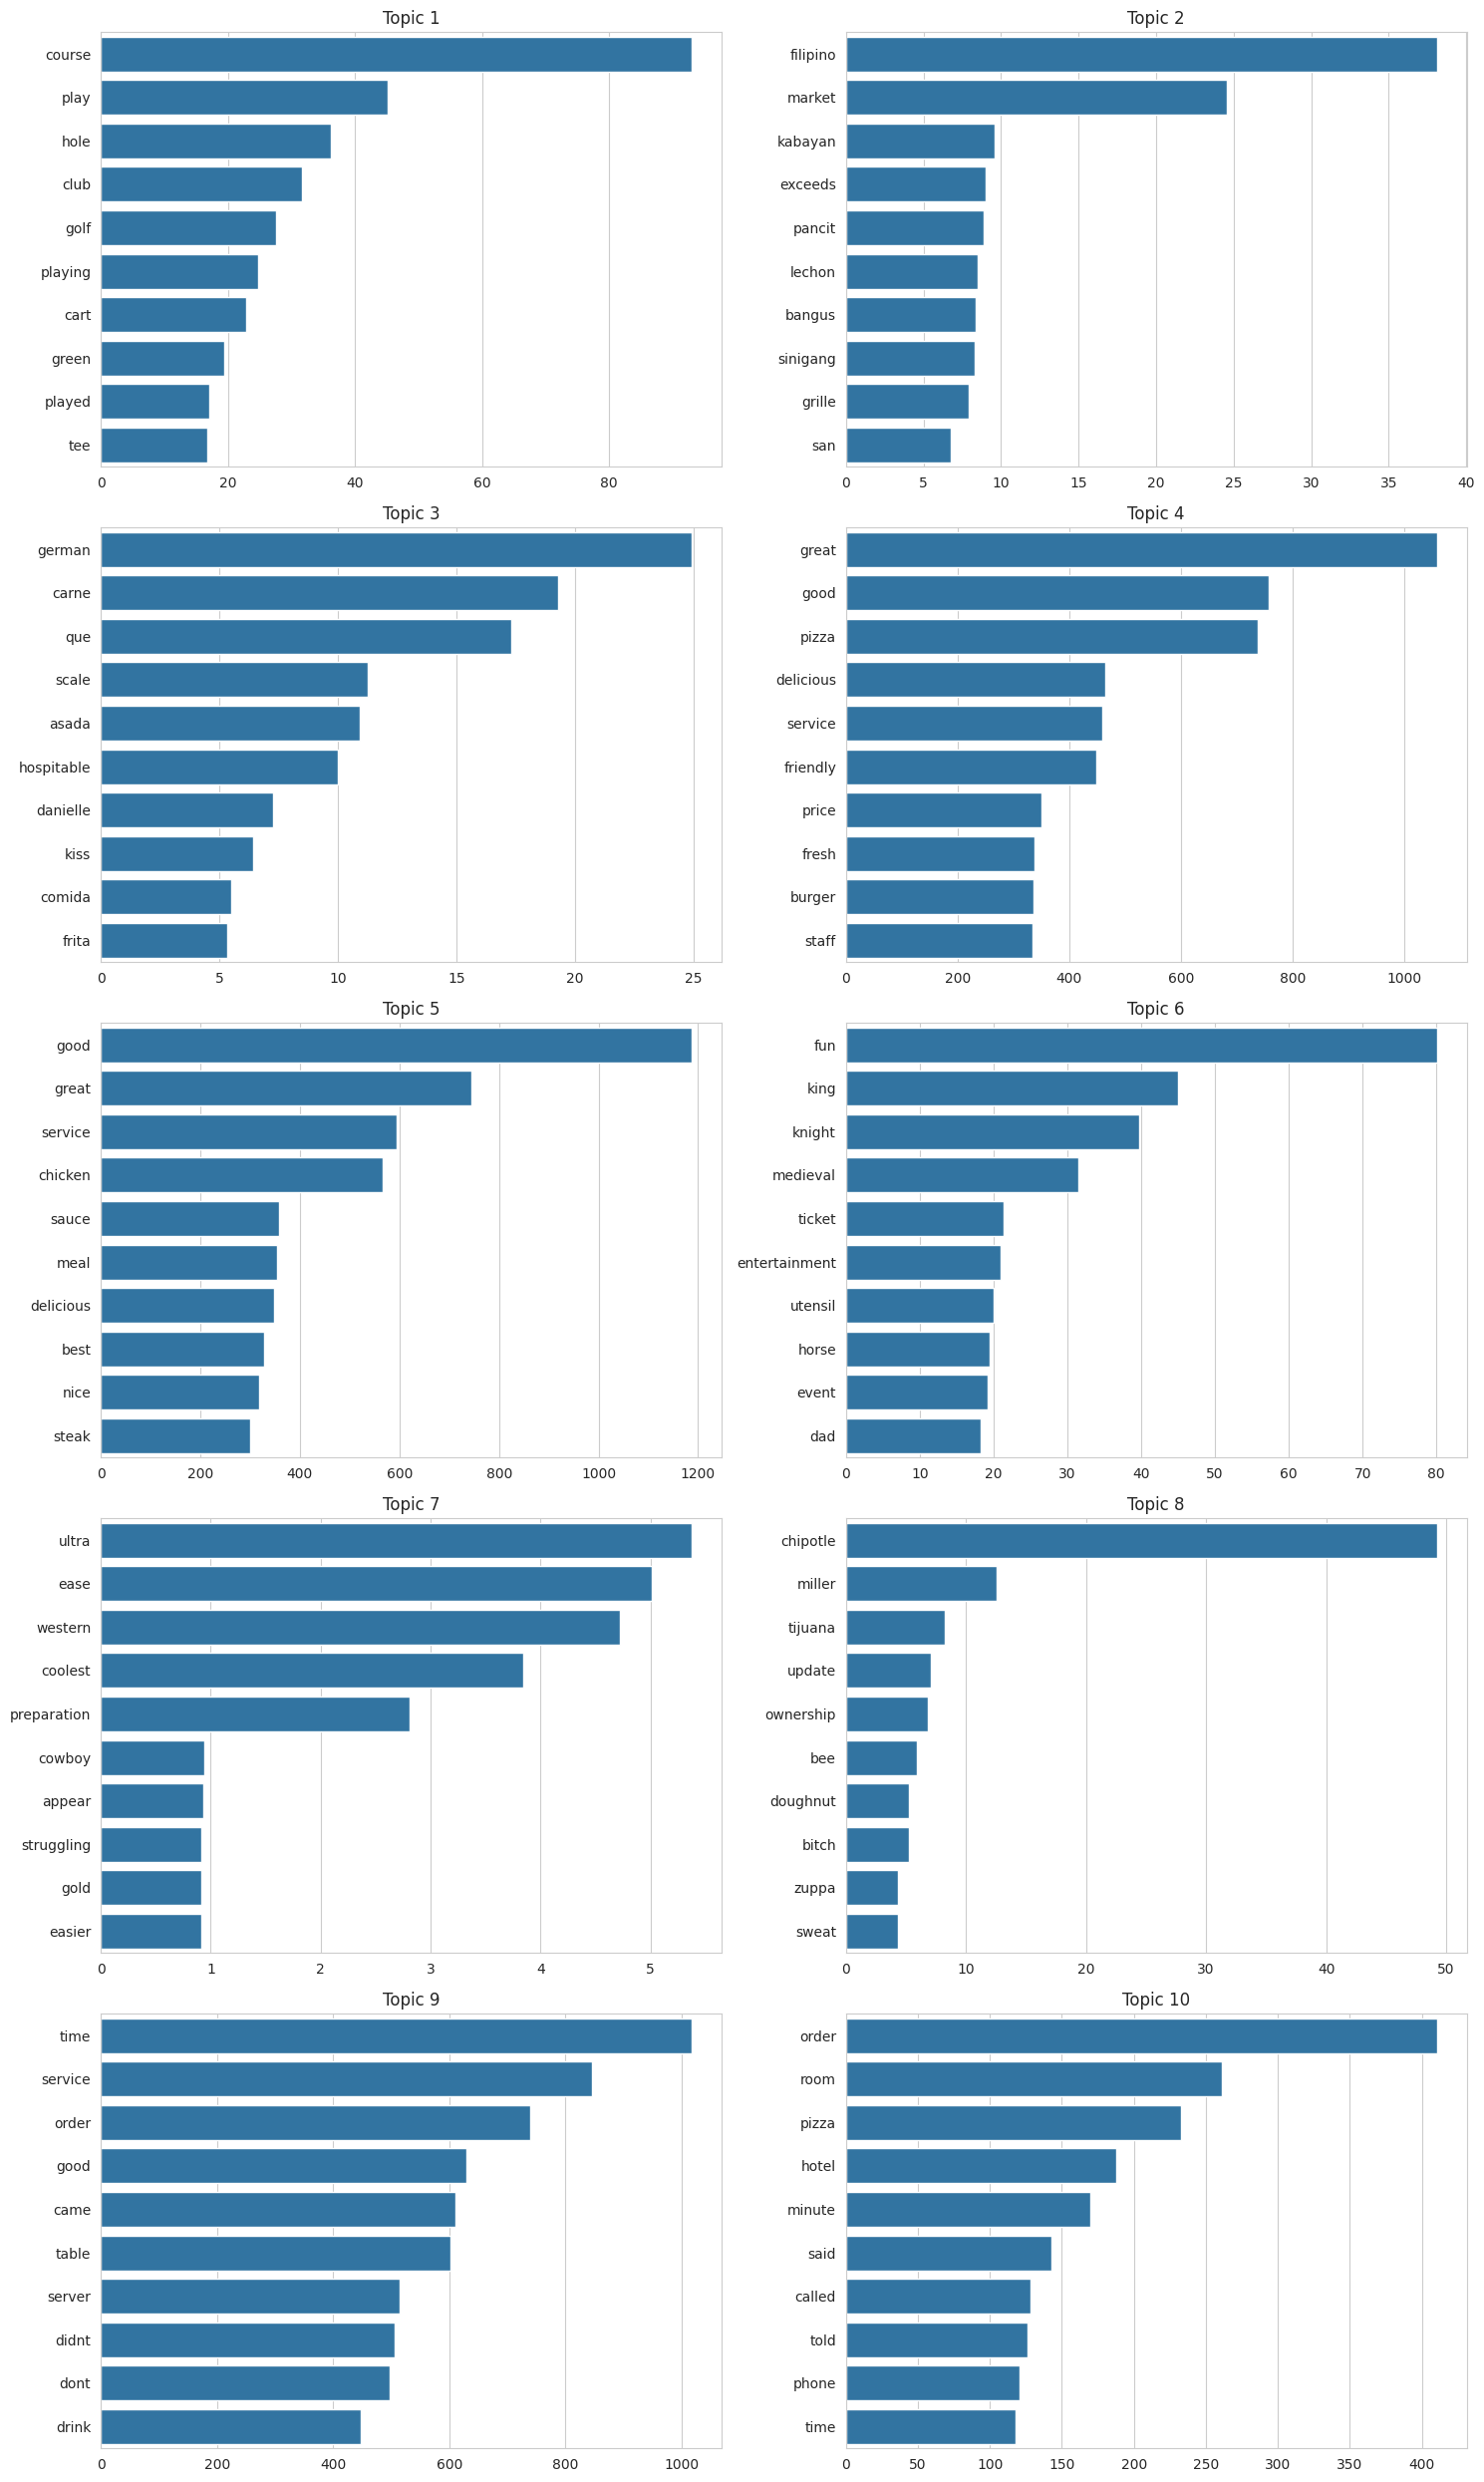


NMF Topic-Term Importance:


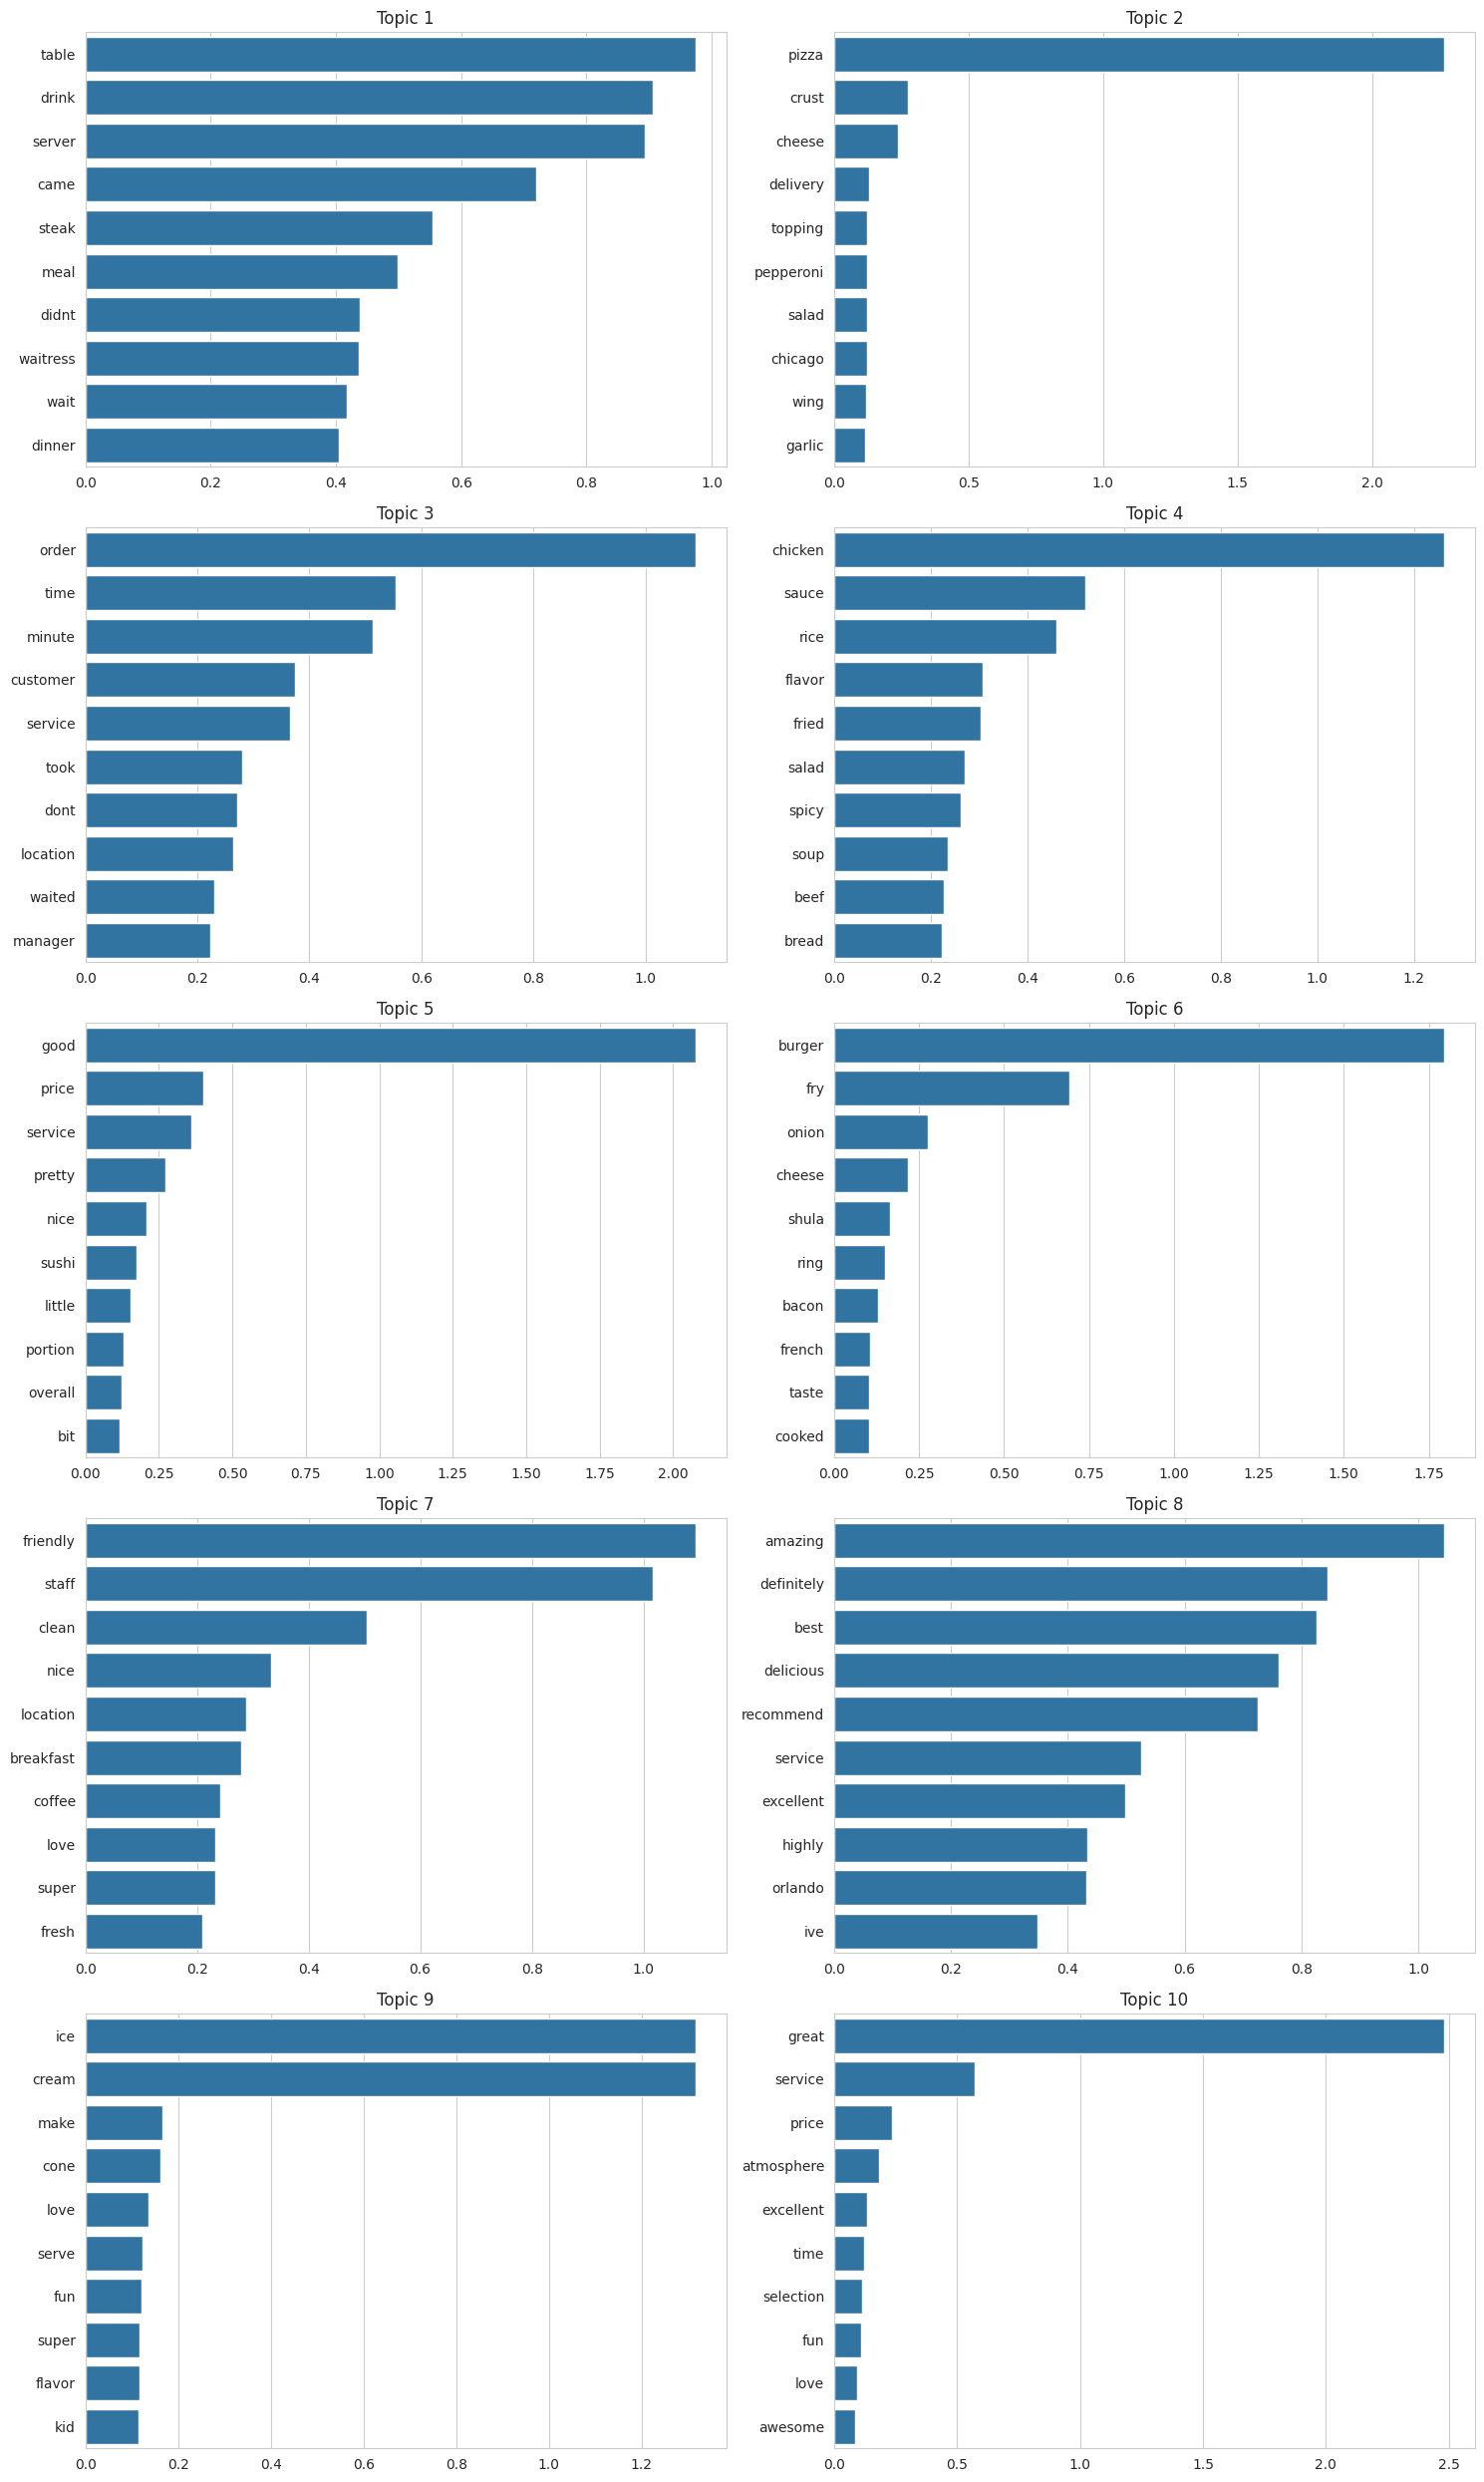


LSA Topic-Term Importance:


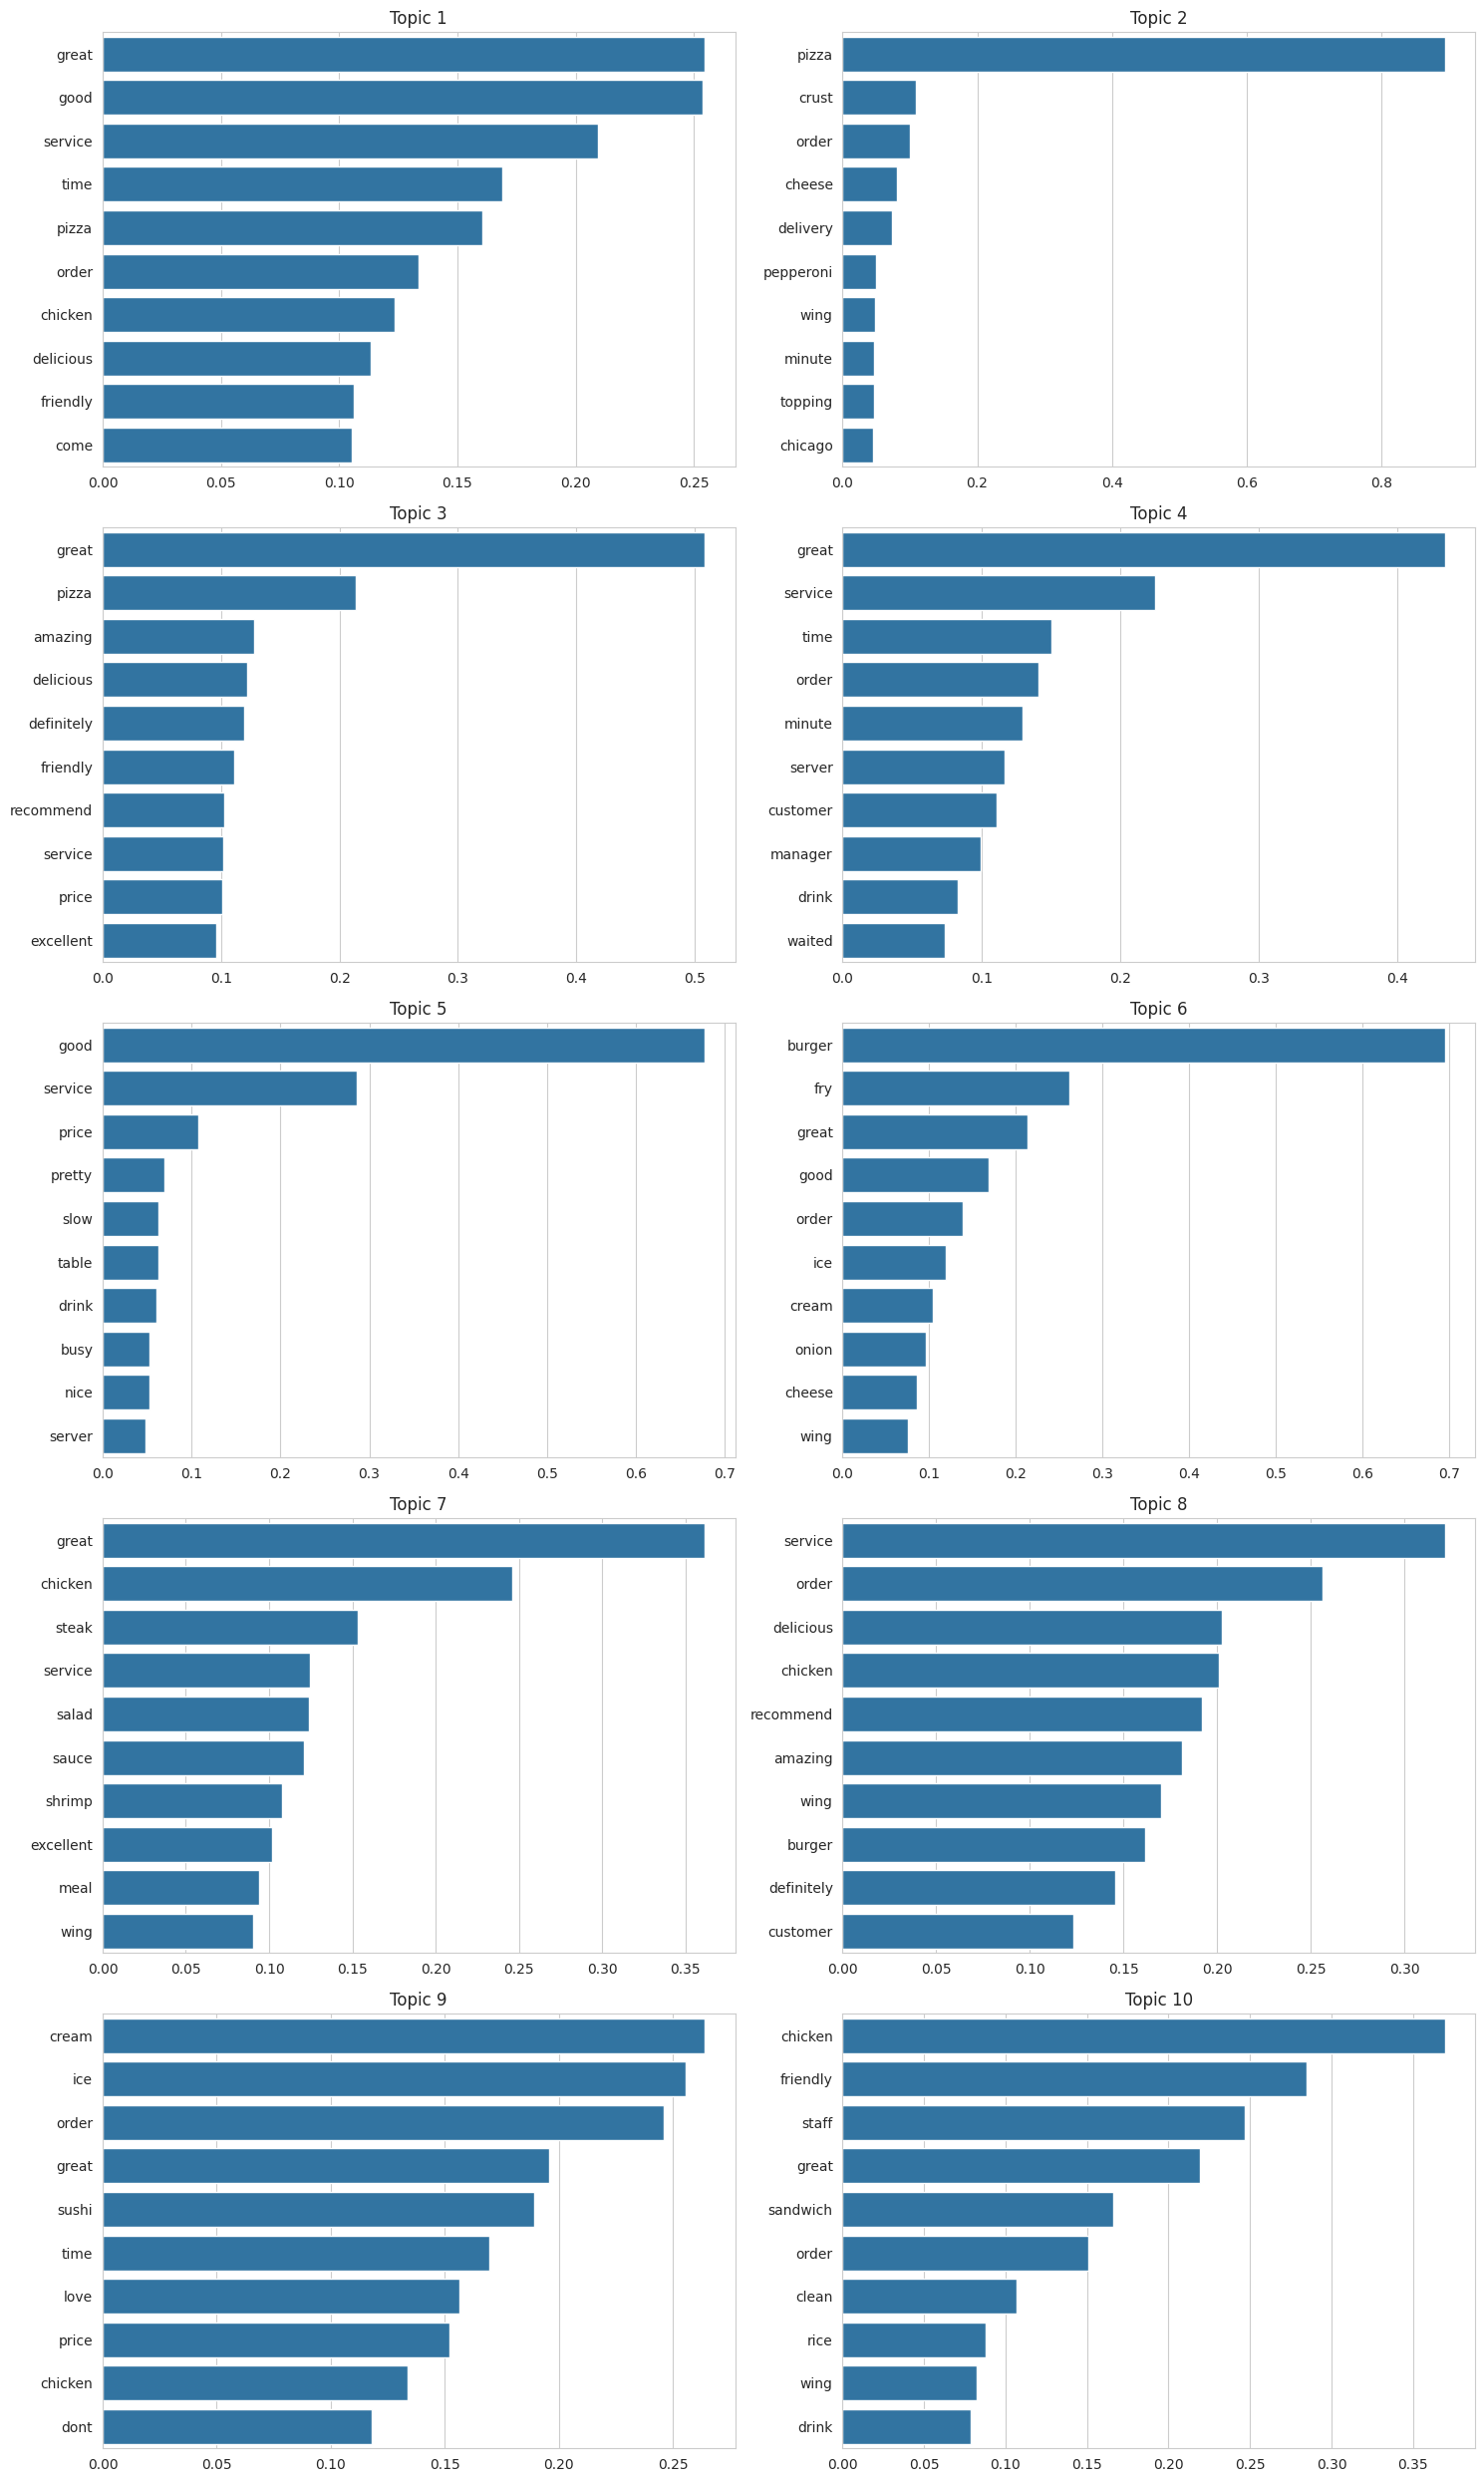

In [73]:
def plot_topic_term_importance(model, feature_names, n_top_terms=10):
    """
    Create static visualization of topic-term importance
    """
    n_topics = model.n_components
    n_rows = int(np.ceil(n_topics/2))
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    axes = axes.ravel()

    for topic_idx, topic in enumerate(model.components_):
        top_terms_idx = topic.argsort()[:-n_top_terms-1:-1]
        top_terms = [feature_names[i] for i in top_terms_idx]
        top_weights = topic[top_terms_idx]

        sns.barplot(x=top_weights, y=top_terms, ax=axes[topic_idx])
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}')

    # Hide empty subplots if odd number of topics
    for idx in range(topic_idx + 1, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Create visualizations for all models
for model_name, (model, _, feat_names) in models.items():
    print(f"\n{model_name} Topic-Term Importance:")
    plot_topic_term_importance(model, feat_names)

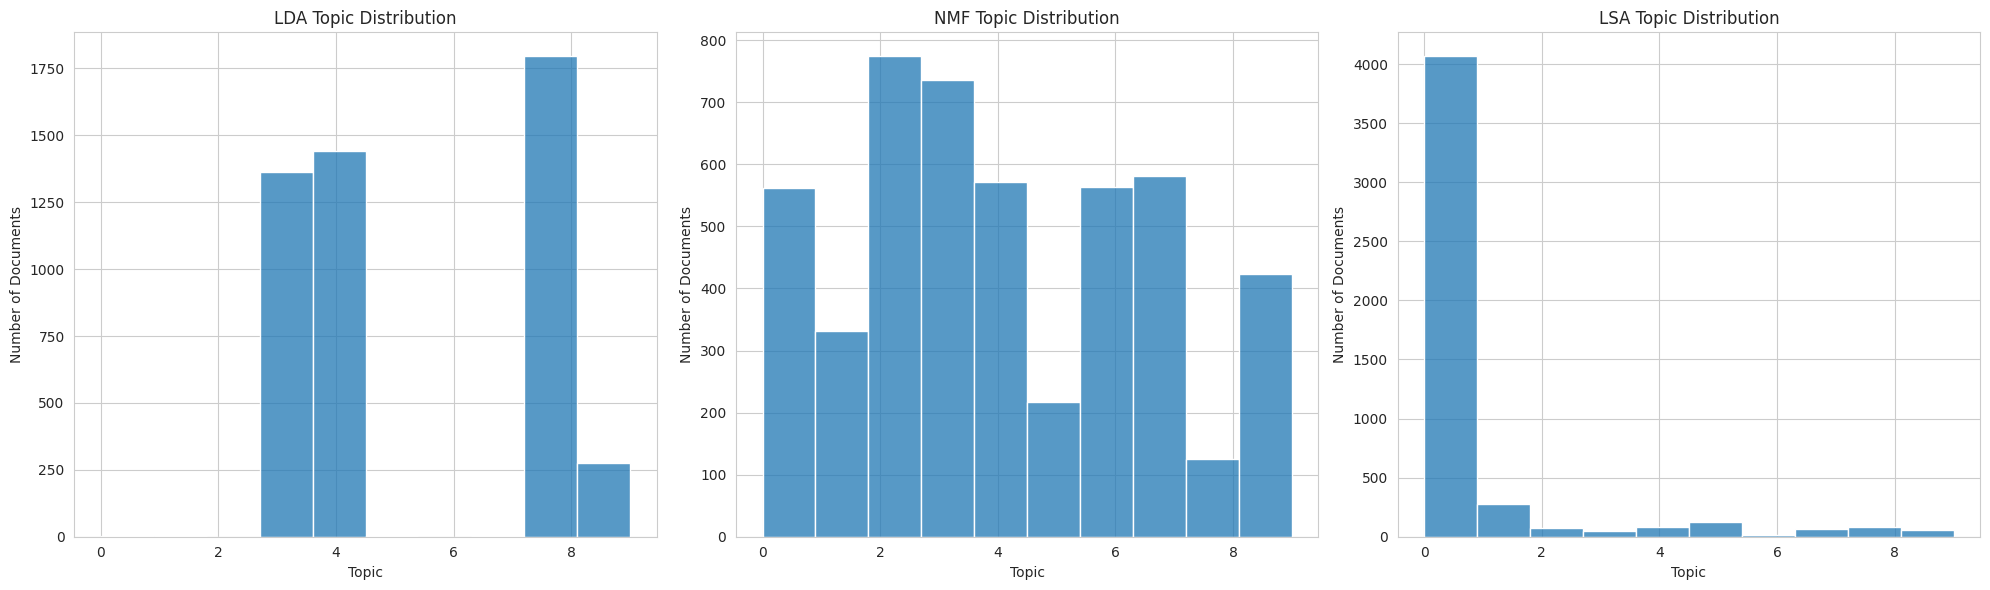

In [74]:
# Additional visualization: Topic Distribution Comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot topic distributions for each model
for idx, (model_name, (model, doc_topics, _)) in enumerate(models.items()):
    dominant_topics = doc_topics.argmax(axis=1)
    sns.histplot(x=dominant_topics, bins=optimal_topics, ax=axes[idx])
    axes[idx].set_title(f'{model_name} Topic Distribution')
    axes[idx].set_xlabel('Topic')
    axes[idx].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

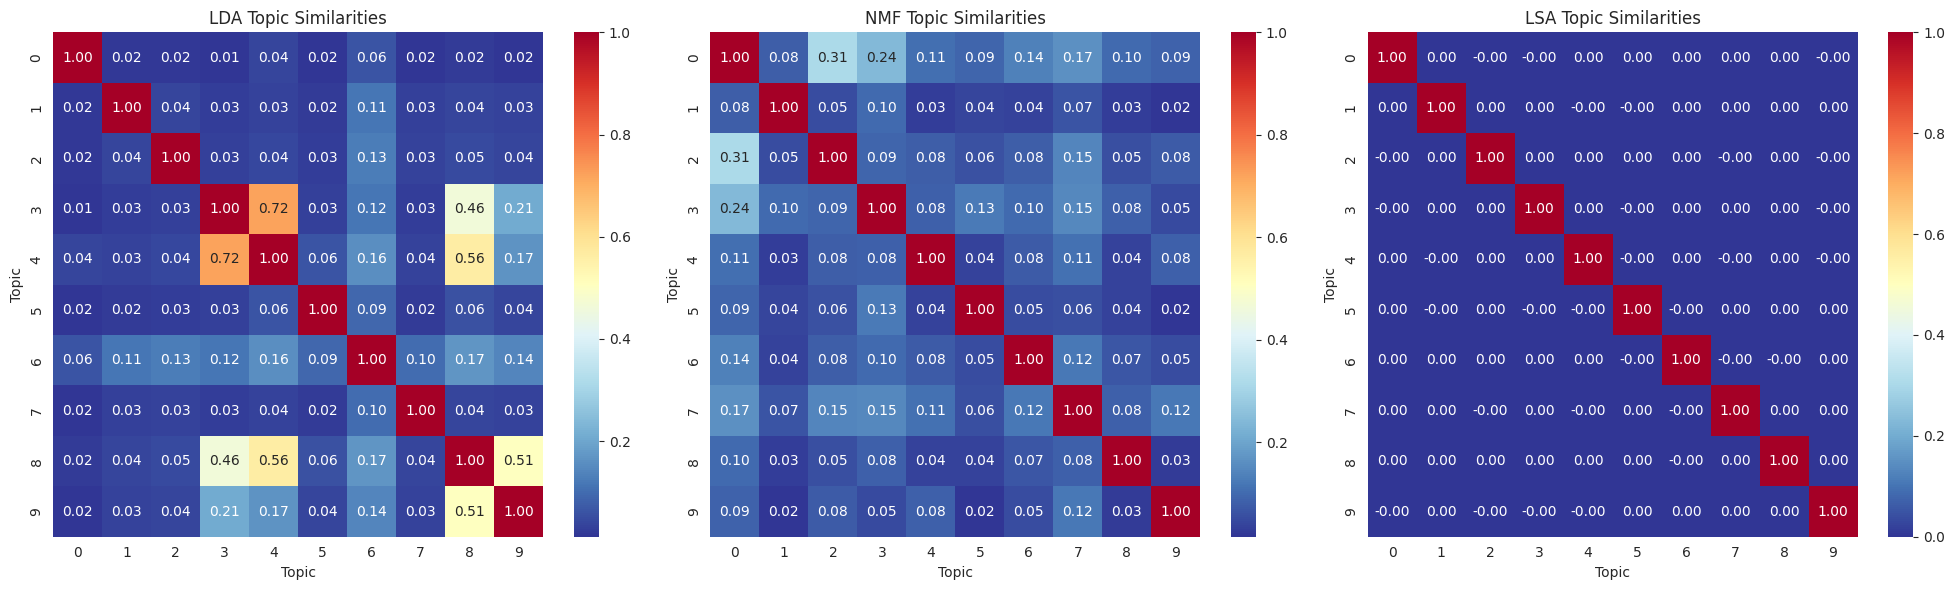

In [75]:
# Topic similarity heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (model_name, (model, _, feat_names)) in enumerate(models.items()):
    # Calculate topic similarities
    topic_word_dist = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    similarities = 1 - cdist(topic_word_dist, topic_word_dist, metric='cosine')

    # Plot heatmap
    sns.heatmap(similarities,
                annot=True,
                cmap='RdYlBu_r',
                ax=axes[idx],
                fmt='.2f')
    axes[idx].set_title(f'{model_name} Topic Similarities')
    axes[idx].set_xlabel('Topic')
    axes[idx].set_ylabel('Topic')

plt.tight_layout()
plt.show()

# SECTION 4: TOPIC ANALYSIS AND INTERPRETATION

## 4.1 Initial Setup and Enhanced Metrics

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from gensim.models.coherencemodel import CoherenceModel
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
from wordcloud import WordCloud
import networkx as nx
from scipy.spatial.distance import cosine, pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Download required resources
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nlp = spacy.load('en_core_web_sm')

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

In [102]:
# Basic topic term extraction
def get_top_terms_per_topic(model, feature_names, n_terms=20):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_terms-1:-1]
        topics.append({
            'topic_id': idx,
            'terms': [feature_names[i] for i in top_indices],
            'weights': topic[top_indices]
        })
    return topics

# Get topic distributions
doc_topic_dist = final_lda.transform(doc_term_matrix)
topics = get_top_terms_per_topic(final_lda, feature_names)

# Print basic topic information
print("Topic Term Distributions:")
for topic in topics:
    print(f"\nTopic {topic['topic_id'] + 1}:")
    for term, weight in zip(topic['terms'][:10], topic['weights'][:10]):
        print(f"{term}: {weight:.4f}")

Topic Term Distributions:

Topic 1:
course: 93.0485
play: 45.1284
hole: 36.2242
club: 31.7053
golf: 27.6570
playing: 24.7895
cart: 22.8558
green: 19.4367
played: 17.1058
tee: 16.7344

Topic 2:
filipino: 38.1278
market: 24.5860
kabayan: 9.5737
exceeds: 9.0414
pancit: 8.9095
lechon: 8.4922
bangus: 8.3414
sinigang: 8.2969
grille: 7.8920
san: 6.7828

Topic 3:
german: 24.9458
carne: 19.2914
que: 17.3366
scale: 11.2489
asada: 10.9475
hospitable: 9.9867
danielle: 7.2843
kiss: 6.4272
comida: 5.5136
frita: 5.3287

Topic 4:
great: 1058.6426
good: 757.0123
pizza: 736.8170
delicious: 463.6739
service: 458.8673
friendly: 449.0043
price: 350.5156
fresh: 336.8140
burger: 336.0340
staff: 334.5872

Topic 5:
good: 1187.7414
great: 744.9577
service: 594.3216
chicken: 565.4736
sauce: 358.0528
meal: 353.6385
delicious: 348.3479
best: 327.7456
nice: 318.0984
steak: 299.2823

Topic 6:
fun: 80.0988
king: 45.0373
knight: 39.7397
medieval: 31.5438
ticket: 21.3025
entertainment: 20.9246
utensil: 19.9723
horse: 1

## 4.2 Topic Analysis Functions

In [104]:
def calculate_topic_metrics(topic_idx, model, feature_names, doc_topics, texts):
    """Calculate comprehensive metrics for a topic"""
    # Topic prevalence
    prevalence = np.mean(doc_topics[:, topic_idx])

    # Topic purity (how exclusively documents belong to this topic)
    dominant_docs = (doc_topics.argmax(axis=1) == topic_idx).sum()
    purity = dominant_docs / len(texts)

    # Topic entropy
    topic_dist = model.components_[topic_idx]
    norm_dist = topic_dist / topic_dist.sum()
    entropy = -np.sum(norm_dist * np.log(norm_dist + 1e-9))

    # Top terms
    top_indices = topic_dist.argsort()[:-11:-1]
    top_terms = [feature_names[i] for i in top_indices]
    top_weights = topic_dist[top_indices]

    return {
        'topic_id': topic_idx,
        'prevalence': prevalence,
        'purity': purity,
        'entropy': entropy,
        'top_terms': top_terms,
        'term_weights': top_weights
    }

In [105]:
# Calculate metrics for all topics
topic_metrics = []
for i in range(final_lda.n_components):
    metrics = calculate_topic_metrics(i, final_lda, feature_names, doc_topic_dist, data_review['text'])
    topic_metrics.append(metrics)

# Convert to DataFrame
topic_metrics_df = pd.DataFrame([
    {k: v for k, v in m.items() if k not in ['top_terms', 'term_weights']}
    for m in topic_metrics
])

In [106]:
topic_metrics_df.head()

,topic_id,prevalence,purity,entropy
0,0,0.006866,0.000614,6.565135
1,1,0.006307,0.000205,7.362263
2,2,0.005859,0.000000,7.576640
3,3,0.261781,0.279222,6.323851
4,4,0.273477,0.295394,6.808054


## 4.3 Sentiment and Semantic Analysis

In [107]:
def analyze_topic_content(topic_idx, texts, doc_topics, threshold=0.3):
    """Detailed content analysis for a topic"""
    # Get relevant documents
    topic_probs = doc_topics[:, topic_idx]
    relevant_docs = texts[topic_probs > threshold]

    # Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiments = []
    semantic_features = defaultdict(list)

    for doc in relevant_docs:
        # VADER sentiment
        vader_scores = sia.polarity_scores(doc)
        # TextBlob sentiment
        blob = TextBlob(doc)
        blob_sentiment = blob.sentiment

        sentiments.append({
            'compound': vader_scores['compound'],
            'positive': vader_scores['pos'],
            'negative': vader_scores['neg'],
            'polarity': blob_sentiment.polarity,
            'subjectivity': blob_sentiment.subjectivity
        })

        # Extract semantic features
        doc_nlp = nlp(doc)
        semantic_features['entities'].extend([ent.label_ for ent in doc_nlp.ents])
        semantic_features['noun_phrases'].extend([np.text for np in doc_nlp.noun_chunks])

    return {
        'sentiments': pd.DataFrame(sentiments),
        'semantic_features': semantic_features,
        'n_documents': len(relevant_docs)
    }

In [108]:
# Analyze topics
topic_content = {}
for i in range(final_lda.n_components):
    topic_content[i] = analyze_topic_content(i, np.array(data_review['text']), doc_topic_dist)

## 4.4 Topic Evolution and Temporal Analysis

In [109]:
def analyze_temporal_patterns(dates, doc_topics, freq='M'):
    """Analyze topic evolution over time"""
    # Convert dates to periods
    dates = pd.to_datetime(dates)
    periods = dates.dt.to_period(freq)

    # Calculate topic distributions over time
    temporal_dist = defaultdict(list)
    for period, topic_dist in zip(periods, doc_topics):
        temporal_dist[period].append(topic_dist)

    # Average distributions per period
    temporal_avg = {
        period: np.mean(dists, axis=0)
        for period, dists in temporal_dist.items()
    }

    # Calculate topic dynamics
    periods_sorted = sorted(temporal_avg.keys())
    topic_dynamics = np.array([temporal_avg[p] for p in periods_sorted])

    return {
        'periods': periods_sorted,
        'distributions': topic_dynamics,
        'changes': np.diff(topic_dynamics, axis=0)
    }

In [110]:
# Calculate temporal patterns if dates are available
if 'date' in data_review.columns:
    temporal_analysis = analyze_temporal_patterns(data_review['date'], doc_topic_dist)

## 4.5 Topic Similarity and Network Analysis

In [111]:
def calculate_topic_similarities(model):
    """Calculate topic similarities using multiple metrics"""
    n_topics = model.n_components
    similarities = np.zeros((n_topics, n_topics))

    # Normalize topic-word distributions
    topics_norm = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # Calculate similarities
    for i in range(n_topics):
        for j in range(n_topics):
            if i != j:
                # Cosine similarity
                cos_sim = 1 - cosine(topics_norm[i], topics_norm[j])
                # Jensen-Shannon divergence
                m = 0.5 * (topics_norm[i] + topics_norm[j])
                js_div = 0.5 * (
                    np.sum(topics_norm[i] * np.log(topics_norm[i] / m + 1e-10)) +
                    np.sum(topics_norm[j] * np.log(topics_norm[j] / m + 1e-10))
                )
                similarities[i,j] = (cos_sim + (1 - js_div)) / 2

    return similarities

In [112]:
# Calculate topic similarities
topic_similarities = calculate_topic_similarities(final_lda)

## 4.6 Interactive Visualizations

In [123]:
def create_meaningful_topic_network(similarities, topic_metrics, feature_names, threshold=0.3):
    """
    Create a topic network visualization with meaningful color coding and consistent sizes
    """
    G = nx.Graph()

    # Get top terms for each topic
    top_terms = {}
    for i in range(len(similarities)):
        top_indices = final_lda.components_[i].argsort()[:-5:-1]
        top_terms[i] = [feature_names[idx] for idx in top_indices]

    # Add nodes with meaningful information
    for i in range(len(similarities)):
        topic_label = f"Topic {i}:\n" + "\n".join(top_terms[i])
        G.add_node(i,
                  label=topic_label,
                  prevalence=topic_metrics[i]['prevalence'])

    # Add meaningful edges
    for i in range(len(similarities)):
        for j in range(i+1, len(similarities)):
            if similarities[i,j] > threshold:
                common_terms = set(top_terms[i]) & set(top_terms[j])
                if common_terms:
                    G.add_edge(i, j,
                              weight=similarities[i,j],
                              common_terms=", ".join(common_terms))

    # Create layout
    pos = nx.spring_layout(G, k=2, iterations=50)

    # Create edge traces
    edge_traces = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]

        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(
                width=2,  # Consistent width
                color='rgba(180,180,180,0.7)'  # Subtle grey
            ),
            hovertext=f"Common terms: {G.edges[edge]['common_terms']}",
            hoverinfo='text',
            mode='lines'
        )
        edge_traces.append(edge_trace)

    # Create node trace
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        mode='markers+text',
        text=[f"Topic {i}" for i in G.nodes()],  # Simplified labels
        textposition="top center",
        hovertext=[f"Topic {i}\nPrevalence: {G.nodes[i]['prevalence']:.3f}\n\n{G.nodes[i]['label']}"
                  for i in G.nodes()],
        hoverinfo='text',
        marker=dict(
            size=30,  # Consistent size
            color=[G.nodes[node]['prevalence'] for node in G.nodes()],
            colorscale=[
                [0, 'rgb(230,230,250)'],      # Light purple
                [0.2, 'rgb(180,180,240)'],     # Medium purple
                [0.4, 'rgb(130,130,230)'],     # Darker purple
                [0.6, 'rgb(80,80,220)'],       # Deep purple
                [0.8, 'rgb(30,30,210)'],       # Very deep purple
                [1, 'rgb(0,0,200)']            # Darkest purple
            ],
            colorbar=dict(
                title='Topic Prevalence',
                thickness=15,
                tickfont=dict(size=10),
                titlefont=dict(size=12)
            ),
            line=dict(color='white', width=1)
        )
    )

    # Create figure
    fig = go.Figure(
        data=edge_traces + [node_trace],
        layout=go.Layout(
            title=dict(
                text='Topic Relationships',
                y=0.95,
                x=0.5,
                xanchor='center',
                yanchor='top',
                font=dict(size=16)
            ),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=[dict(
                text="Darker color indicates higher topic prevalence",
                showarrow=False,
                xref="paper", yref="paper",
                x=0, y=-0.1,
                font=dict(size=12)
            )],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor='white',
            width=1000,
            height=800
        )
    )

    # Update hover label style
    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )

    return fig



In [124]:
# Create and display the visualization
network_fig = create_meaningful_topic_network(
    topic_similarities,
    topic_metrics,
    feature_names,
    threshold=0.3
)
network_fig.show()

## 4.7 Document-Level Analysis

In [115]:
def analyze_document_topic_composition(doc_topics, texts, threshold=0.2):
    """Analyze how topics are distributed across documents"""
    # Calculate document-level metrics
    doc_metrics = []

    for idx, (dist, text) in enumerate(zip(doc_topics, texts)):
        # Get topics above threshold
        significant_topics = np.where(dist > threshold)[0]

        # Calculate entropy of distribution
        norm_dist = dist / dist.sum()
        entropy = -np.sum(norm_dist * np.log(norm_dist + 1e-9))

        doc_metrics.append({
            'doc_id': idx,
            'dominant_topic': dist.argmax(),
            'n_significant_topics': len(significant_topics),
            'max_topic_prob': dist.max(),
            'topic_entropy': entropy,
            'text_length': len(text)
        })

    return pd.DataFrame(doc_metrics)

In [116]:
# Analyze documents
doc_analysis = analyze_document_topic_composition(doc_topic_dist, data_review['text'])

In [127]:
doc_analysis

,doc_id,dominant_topic,n_significant_topics,max_topic_prob,topic_entropy,text_length
0,0,0,2,0.481527,1.100063,640
1,1,3,1,0.943747,0.340129,197
2,2,3,2,0.715078,0.721783,465
3,3,4,2,0.466100,1.248749,1343
4,4,8,2,0.588121,0.800622,1013
...,...,...,...,...,...,...
4880,4880,3,1,0.811783,0.691573,551
4881,4881,3,1,0.949998,0.308389,246
4882,4882,8,1,0.924991,0.431217,162
4883,4883,8,2,0.563774,1.044761,928
